# Анализ временных рядов и прогнозирование на примере пассажирского трафика метро

<div class='alert alert-block alert-info'>
    <p><b>О наборе данных:</b> Ежечасная информация о количестве пассажиров в переходе между двумя станциями метро в американсокм городе.</p>
    <p>Дополнительно приведены сведения о погоде..</p>
    <p><a href='https://archive.ics.uci.edu/ml/datasets/Metro+Interstate+Traffic+Volume'>Источник.</a></p>
    <p>Traffic data from MN Department of Transportation. Weather data from OpenWeatherMap.</p>
</div>

<div class='alert alert-block alert-warning'>
    <p><b>Цель: </b>Оценка точности прогнозирования различных моделей.</p>    
</div>

1. <a href='#1'>Анализ и подготовка данных</a>  
    1.1 <a href='#11'>Чтение данных из файла</a>  
    1.2 <a href='#12'>Анализ данных</a>  
    1.3 <a href='#13'>Подготовка данных</a>  
    1.4 <a href='#14'>Выделение компонент временного ряда: тренда и периодичности</a>  
2. <a href='#20'>Построение моделей прогнозирования</a>  
    2.1 <a href='#21'>Подбор параметров модели SARIMAX</a>  
    2.2 <a href='#22'>Раздельное прогнозирование тренда и периодической составляющей</a>  
    2.3 <a href='#23'>Перекрёстная проверка точности моделей прогнозирования SARIMAX</a>  
    2.4 <a href='#24'>Сравнение точностей предсказания температуры воздуха на 1 и 3 дня</a>  
    2.5 <a href='#25'>Тестирование модели Prophet от Facebook</a>  
3. <a href='#30'>Общие результаты и выводы</a>

In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns

import pickle

## <a id='1'>1. Анализ и подготовка данных</a>

### <a id='1.1'>1.1 Чтение данных из файла</a>

In [3]:
data_file_name = './data/Metro_Interstate_Traffic_Volume.csv'

In [4]:
raw_data_frame = pd.read_csv(data_file_name, encoding='utf8', sep=',')[16000:].drop_duplicates()

In [5]:
raw_data_frame.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32187 entries, 16000 to 48203
Data columns (total 9 columns):
holiday                32187 non-null object
temp                   32187 non-null float64
rain_1h                32187 non-null float64
snow_1h                32187 non-null float64
clouds_all             32187 non-null int64
weather_main           32187 non-null object
weather_description    32187 non-null object
date_time              32187 non-null object
traffic_volume         32187 non-null int64
dtypes: float64(3), int64(2), object(4)
memory usage: 2.5+ MB


In [6]:
raw_data_frame['date_time'] = raw_data_frame['date_time'].apply(pd.to_datetime)

In [7]:
raw_data_frame.head(20)

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume
16000,None,291.093,0.0,0.0,88,Rain,light rain,2015-06-25 03:00:00,352
16001,None,299.340,0.0,0.0,1,Clear,sky is clear,2015-06-25 13:00:00,5116
16002,None,299.530,0.0,0.0,75,Clouds,broken clouds,2015-06-25 14:00:00,5264
16003,None,299.900,0.0,0.0,40,Clouds,scattered clouds,2015-06-25 15:00:00,6122
16004,None,299.800,0.0,0.0,40,Clouds,scattered clouds,2015-06-25 16:00:00,6277
16005,None,299.520,0.0,0.0,75,Clouds,broken clouds,2015-06-25 17:00:00,5996
16006,None,298.520,0.0,0.0,1,Clear,sky is clear,2015-06-25 19:00:00,3843
16007,None,297.460,0.0,0.0,1,Clear,sky is clear,2015-06-25 20:00:00,3207
16008,None,295.250,0.0,0.0,1,Clear,sky is clear,2015-06-25 21:00:00,3189
16009,None,293.360,0.0,0.0,1,Clear,sky is clear,2015-06-25 22:00:00,2469


In [8]:
raw_data_frame.duplicated(subset=['date_time', 'traffic_volume']).value_counts()

False    26648
True      5539
dtype: int64

In [9]:
raw_data_frame.duplicated(subset=['temp', 'date_time', 'traffic_volume']).value_counts()

False    26702
True      5485
dtype: int64

<div class='alert alert-block alert-warning'>В исходном файле имеются дубликаты.</div>

In [10]:
raw_data_frame = raw_data_frame.drop(['rain_1h', 'snow_1h', 'clouds_all', 'weather_main', 'weather_description', 'holiday'], axis=1).set_index('date_time').drop_duplicates()
raw_data_frame

,temp,traffic_volume
date_time,,
2015-06-25 03:00:00,291.093,352
2015-06-25 13:00:00,299.340,5116
2015-06-25 14:00:00,299.530,5264
2015-06-25 15:00:00,299.900,6122
2015-06-25 16:00:00,299.800,6277
...,...,...
2018-09-30 19:00:00,283.450,3543
2018-09-30 20:00:00,282.760,2781
2018-09-30 21:00:00,282.730,2159


In [11]:
raw_data_frame.duplicated().value_counts()

False    26677
dtype: int64

### <a id='12'>1.2 Анализ данных</a>

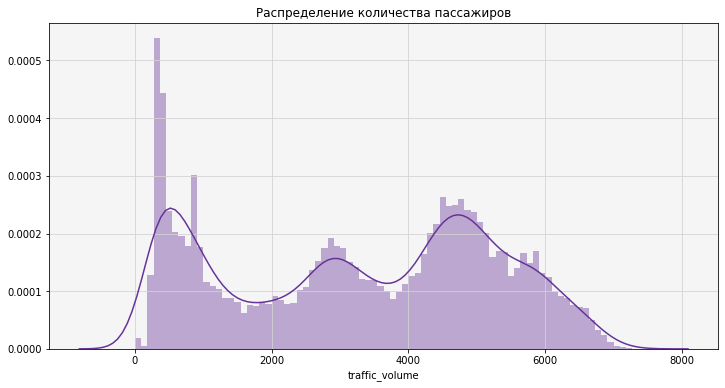

In [12]:
fig, ax = plt.subplots(figsize=(12,6))
sns.distplot(raw_data_frame['traffic_volume'], bins=80, color='rebeccapurple', ax=ax)
ax.set_facecolor('whitesmoke')
ax.grid(color='lightgray')
ax.set_title('Распределение количества пассажиров');

#### Распределение значений количества пассажирова имеет 3 выраженных максимума.
#### Возможно, они соответствуют двум пикам нагрузки - в будние дни и выходные, а также минимуму нагрузки в ночные часы (станции открыты круглосуточно).

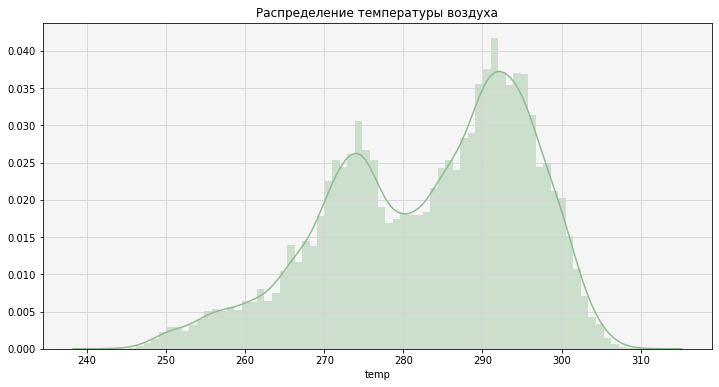

In [13]:
fig, ax = plt.subplots(figsize=(12,6))
sns.distplot(raw_data_frame['temp'], bins=70, color='darkseagreen', ax=ax)
ax.set_facecolor('whitesmoke')
ax.grid(color='lightgray')
ax.set_title('Распределение температуры воздуха');

#### Распределение значений температуры воздуха имеет два выраженных максимума.
#### Вероятно, они соответствуют средним температурам летнего и зимнего сезонов.

### <a id='13'>1.3 Подготовка данных</a>

<div class='alert alert-block alert-warning'>
    <p>В исходных данных нарушен равномерность временных интервалов, т.е. не все значения отстоят друг от друга на 1 час.</p>
    <p>Во-первых, нужно <b>сгененрировать равномерную последовательность</b> временных индексов</p>
    <p>Во-вторых, нужно <b>интерполировать</b> пропущенные значения.</p>
</div>

In [14]:
raw_data_frame.index.min()

Timestamp('2015-06-25 03:00:00')

In [15]:
raw_data_frame.index.max()

Timestamp('2018-09-30 23:00:00')

In [16]:
interpolated_timestamps = pd.date_range(start=raw_data_frame.index.min(), end=raw_data_frame.index.max(), freq='1H')
interpolated_timestamps

DatetimeIndex(['2015-06-25 03:00:00', '2015-06-25 04:00:00',
               '2015-06-25 05:00:00', '2015-06-25 06:00:00',
               '2015-06-25 07:00:00', '2015-06-25 08:00:00',
               '2015-06-25 09:00:00', '2015-06-25 10:00:00',
               '2015-06-25 11:00:00', '2015-06-25 12:00:00',
               ...
               '2018-09-30 14:00:00', '2018-09-30 15:00:00',
               '2018-09-30 16:00:00', '2018-09-30 17:00:00',
               '2018-09-30 18:00:00', '2018-09-30 19:00:00',
               '2018-09-30 20:00:00', '2018-09-30 21:00:00',
               '2018-09-30 22:00:00', '2018-09-30 23:00:00'],
              dtype='datetime64[ns]', length=28653, freq='H')

In [17]:
evenly_spaced_data = pd.DataFrame(index=interpolated_timestamps)
evenly_spaced_data = evenly_spaced_data.join(raw_data_frame)

In [18]:
evenly_spaced_data.head(20)

,temp,traffic_volume
2015-06-25 03:00:00,291.093,352.0
2015-06-25 04:00:00,NaN,NaN
2015-06-25 05:00:00,NaN,NaN
2015-06-25 06:00:00,NaN,NaN
2015-06-25 07:00:00,NaN,NaN
2015-06-25 08:00:00,NaN,NaN
2015-06-25 09:00:00,NaN,NaN
2015-06-25 10:00:00,NaN,NaN
2015-06-25 11:00:00,NaN,NaN
2015-06-25 12:00:00,NaN,NaN


In [19]:
evenly_spaced_data['temp'].isnull().value_counts()

False    26677
True      2030
Name: temp, dtype: int64

In [20]:
interpolated_data = evenly_spaced_data.interpolate(method='linear', axis=0)

In [21]:
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

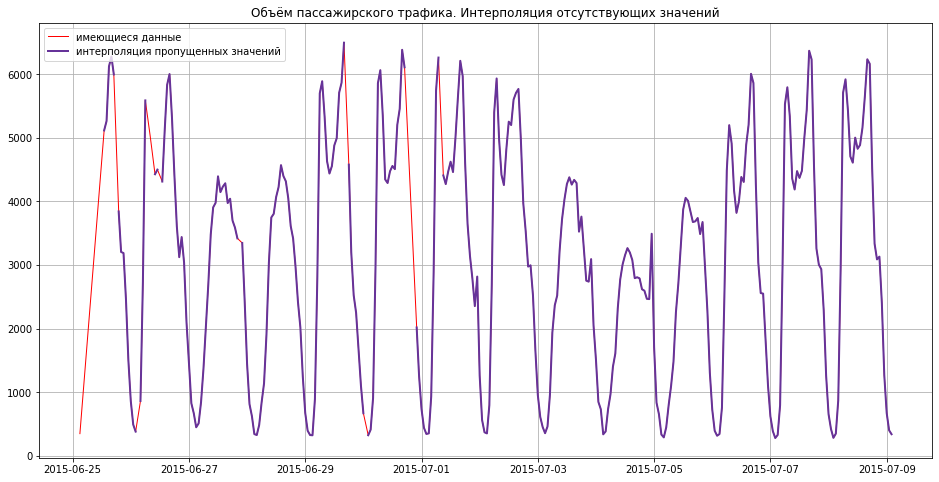

In [22]:
fig, ax = plt.subplots(figsize=(16,8));
ax.plot_date(interpolated_data.index[:24*7*2], interpolated_data['traffic_volume'][:24*7*2], fmt='-', color='red', lw=1, label='имеющиеся данные');
ax.plot_date(evenly_spaced_data.index[:24*7*2], evenly_spaced_data['traffic_volume'][:24*7*2], fmt='-', color='rebeccapurple', alpha=1.0, lw=2, label='интерполяция пропущенных значений');
ax.grid()
ax.legend()
ax.set_title('Объём пассажирского трафика. Интерполяция отсутствующих значений', fontsize=12);

## <a id='14'>1.4 Выделение компонент временного ряда - тренда и периодичности</a>

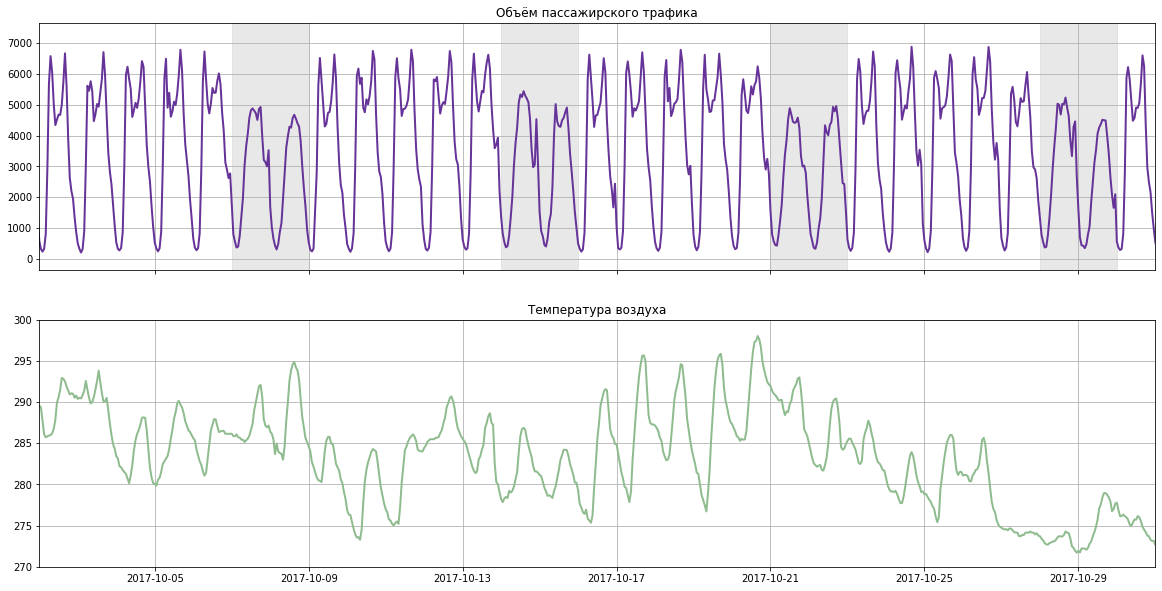

In [23]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(20,10), sharex='col');
ax[0].plot_date(interpolated_data.index, interpolated_data['traffic_volume'], fmt='-', color='rebeccapurple', lw=2, label='traffic');
ax[0].axvspan('2017-10-07 00:00:00', '2017-10-09 00:00:00', color='lightgray', alpha=0.5);
ax[0].axvspan('2017-10-14 00:00:00', '2017-10-16 00:00:00', color='lightgray', alpha=0.5);
ax[0].axvspan('2017-10-21 00:00:00', '2017-10-23 00:00:00', color='lightgray', alpha=0.5);
ax[0].axvspan('2017-10-28 00:00:00', '2017-10-30 00:00:00', color='lightgray', alpha=0.5);
ax[0].set_xlim(['2017-10-02 00:00:00', '2017-10-31 00:00:00']);
ax[0].grid()
ax[0].set_title('Объём пассажирского трафика');

ax[1].plot_date(interpolated_data.index, interpolated_data['temp'], fmt='-', color='darkseagreen', lw=2, label='temperature');
ax[1].set_ylim([270,300]);
ax[1].grid()
ax[1].set_title('Температура воздуха');

#### В данных по количеству пассажиров в переходе явно наблюдается недельная периодичность. Тренд на месячной выборке не наблюдается.
#### При этом, не глядя на даты, можно определить интервалы, соответствующие субботним и воскресным дням - в них объём трафика заметно меньше.
#### Цикл значений температуры воздуха, вполне естественно, составляет 24 часа. Нецикличный тренд явно выражен даже на интервале 2-3 дня.

In [24]:
from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error

def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [25]:
traffic_data = interpolated_data.drop(['temp'], axis=1).reset_index(drop=True)
temperature_data = interpolated_data.drop(['traffic_volume'], axis=1).reset_index(drop=True)

In [26]:
traffic_data

,traffic_volume
0,352.0
1,828.4
2,1304.8
3,1781.2
4,2257.6
...,...
28702,3543.0
28703,2781.0
28704,2159.0
28705,1450.0


In [27]:
def plot_rolling_mean(data, window_size, window_type=None, show_intervals=False, z_interval=2.0):
    x_range = (data.index.min(), data.index.max())
    half_window_size = int(np.ceil(window_size * 0.5))
    fig,ax = plt.subplots(figsize=(20,10));
    ax.set_xlim([x_range[0]+half_window_size, x_range[1] - half_window_size])
    
    # сглаженные данные - средние значения для каждого окна
    rolling_mean = data.rolling(window=window_size, win_type=window_type).mean(center=True)
    
    ax.plot(data, linestyle='solid', color ='tan', lw=1)
    ax.plot(rolling_mean, linestyle='solid', color ='darkorange', lw=2)
    ax.grid()
    
    # 
    if True==show_intervals:
        mae = mean_absolute_error(data[half_window_size:-half_window_size], rolling_mean[half_window_size:-half_window_size])
        intervals = mae + np.std(data - rolling_mean) * z_interval
        upper_boundaries = rolling_mean + intervals
        lower_boundaries = rolling_mean - intervals        
        ax.fill_between(x=data.index, y1=rolling_mean, y2=upper_boundaries, color='moccasin', alpha=0.4)
        ax.fill_between(x=data.index, y1=rolling_mean, y2=lower_boundaries, color='moccasin', alpha=0.4)

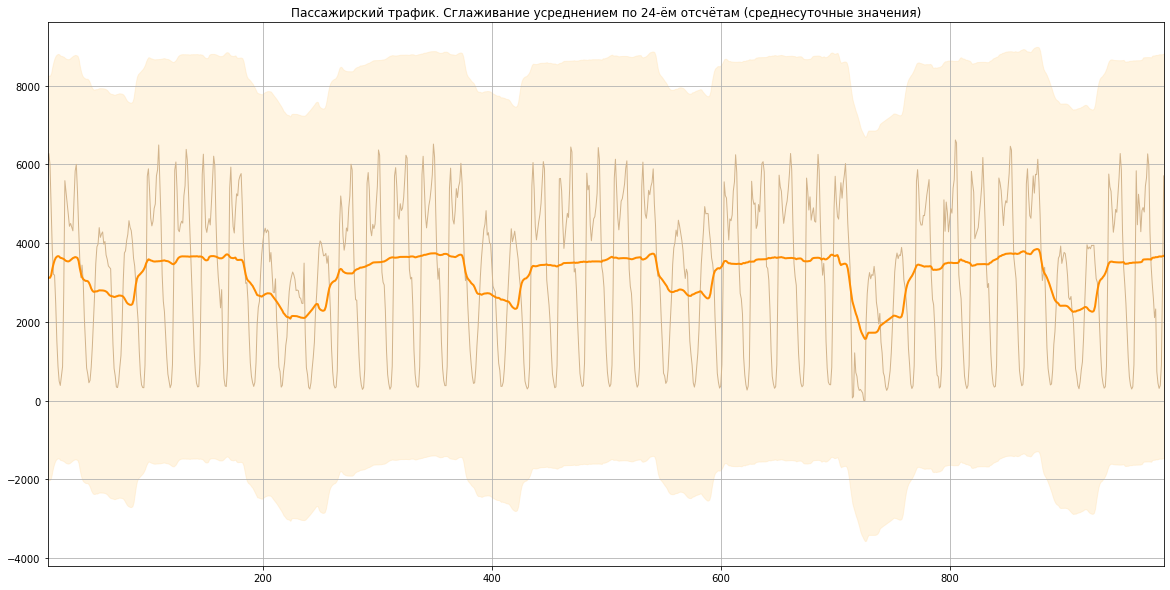

In [28]:
plot_rolling_mean(traffic_data['traffic_volume'][:1000], window_size=24, show_intervals=True)
plt.title('Пассажирский трафик. Сглаживание усреднением по 24-ём отсчётам (среднесуточные значения)');

#### Усреднение в интервале 24 часа позволяет наблюдать дневной тренд пассажирского трафика - примерно постоянный объём в будни и спад в выходные.
#### Дневной тренд имеет выраженную недельную цикличность (повторяемость).

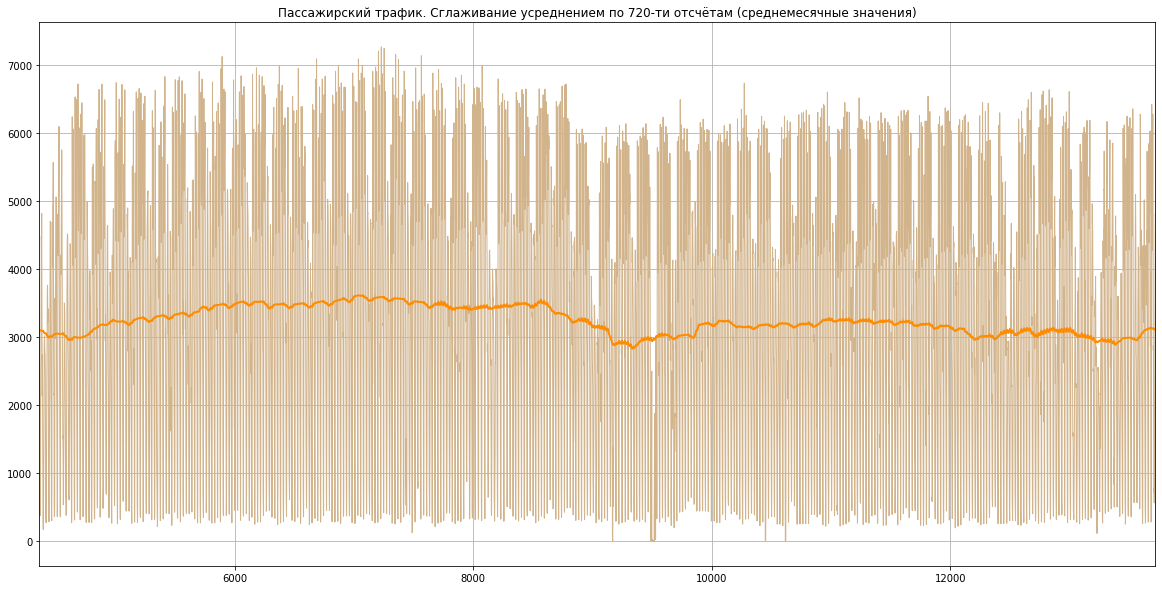

In [29]:
plot_rolling_mean(traffic_data['traffic_volume'][4000:4000+720*14], window_size=720)
plt.title('Пассажирский трафик. Сглаживание усреднением по 720-ти отсчётам (среднемесячные значения)');

#### На выборке за 1 год с усреднением на месячном интервале можно наблюдать более медленный тренд.
#### Видны спады трафика в начале года и в летние месяцы.

In [30]:
import statsmodels.api as sm

In [31]:
traffic_uc_model = sm.tsa.UnobservedComponents(
    traffic_data['traffic_volume'][:1000],
    'strend',
    seasonal=24*7
)

In [32]:
#traffic_uc_result = traffic_uc_model.fit(method='powell', disp=False)

In [33]:
#traffic_uc_result.save('./models/traffic_uc_result.pkl')

In [34]:
traffic_uc_result = pickle.load(open('./models/traffic_uc_result.pkl', 'rb'))

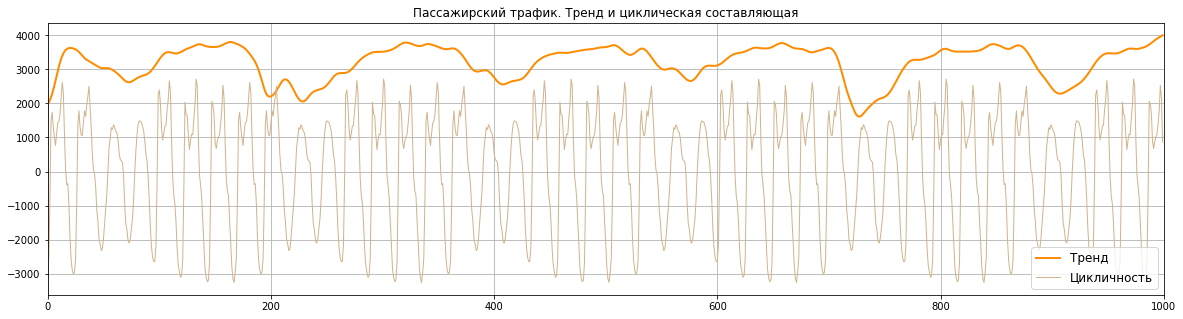

In [35]:
fig, ax = plt.subplots(figsize=(20,5))
    
ax.plot(traffic_uc_result.level.smoothed[:1000], linestyle='solid', color ='darkorange', lw=2, label='Тренд');
ax.plot(traffic_uc_result.seasonal.smoothed[:1000], linestyle='solid', color ='tan', lw=1, label='Цикличность');

ax.set_xlim([0,1000]);
ax.grid();
ax.legend(loc='lower right', fontsize=12);
ax.set_title('Пассажирский трафик. Тренд и циклическая составляющая');

#### Разделение временного ряда на циклическую составляющую и тренд эконометрическими методами.
#### Результат моделирования близок к полученному при выделелни тренда усреднением скользящим окном.

In [36]:
temperature_uc_model = sm.tsa.UnobservedComponents(
    temperature_data['temp'][:1000],
    'strend',
    seasonal=24
)

In [37]:
temperature_uc_result = temperature_uc_model.fit(method='powell', disp=False)

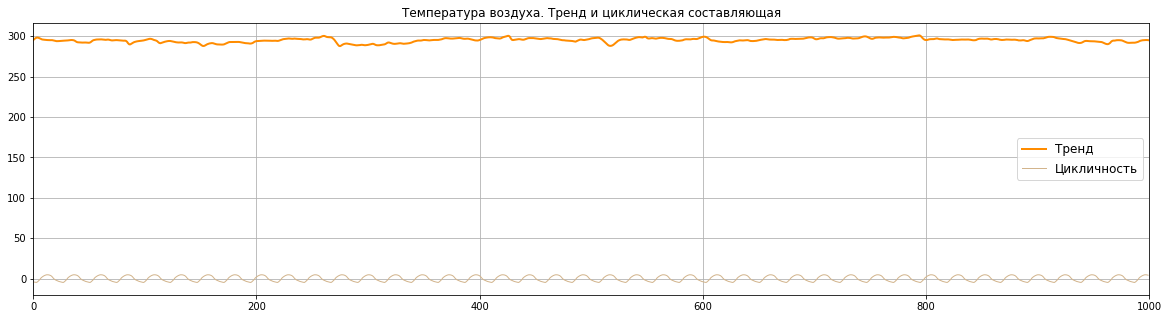

In [38]:
fig, ax = plt.subplots(figsize=(20,5))
    
ax.plot(temperature_uc_result.level.smoothed, linestyle='solid', color ='darkorange', lw=2, label='Тренд');
ax1 = ax.twinx()
ax1.plot(temperature_uc_result.seasonal.smoothed, linestyle='solid', color ='tan', lw=1, label='Цикличность');
ax.set_xlim([0,1000]);
ax.grid();
ax.legend(loc='center right', fontsize=12);
ax.set_title('Температура воздуха. Тренд и циклическая составляющая');

#### Эконометрическая модель разделила суточный цикл и тренд во временном ряде температуры воздуха.

In [39]:
from statsmodels.graphics.api import tsa

In [40]:
def custom_plot_acf(data, lags=None, color='blue', style='stem', figsize=(8,6), title=None):    
    if lags is None or lags > 0.5*len(data) - 1:
        lags = 0.5*len(data) - 1
    acf = tsa.acf(data, unbiased=False, nlags=lags, fft=True);
    acf_max_index = 0
    acf_max= -1
    for i in range(1, lags):
        if acf[i]>acf[i+1] and acf[i]>acf[i-1] and acf[i] > acf_max:
            acf_max_index = i
            acf_max = acf[i]    
    x_range = range(lags);
    
    acf_range = [np.min(acf), np.max(acf)]
    if acf_range[0] > 0:
        acf_range[0] = 0
    if acf_max > 0.95:
        acf_range[1] = 1.1
        
    baseline_relative_height = np.abs(acf_range[0]) / (acf_range[1] - acf_range[0])
    peak_relative_height = np.abs(acf_max - acf_range[0]) / (acf_range[1] - acf_range[0])
        
    fig, ax = plt.subplots(figsize=figsize);
    ax.set_ylim(acf_range)
    ax.set_xlim([-1, lags])
    
    if 'stem'==style:
        markerline, stemlines, baseline = ax.stem(acf, use_line_collection=True, linefmt=color, markerfmt=',')
        baseline.set_color('gray')
    elif 'line'==style:
        ax.plot(acf, color=color)
    else:
        print("style can be either 'stem' or 'line'")
        return
        
    ax.axvline(x=acf_max_index, ymin=baseline_relative_height, ymax=peak_relative_height, color='red', lw=2)
    ax.text(x=acf_max_index, y=acf[acf_max_index]+0.02*(acf_range[1] - acf_range[0]), s=f'$max@{acf_max_index}$', fontsize=12)

    
    ax.grid()
    
    if title is not None:
        ax.set_title(label=title, fontsize=12)

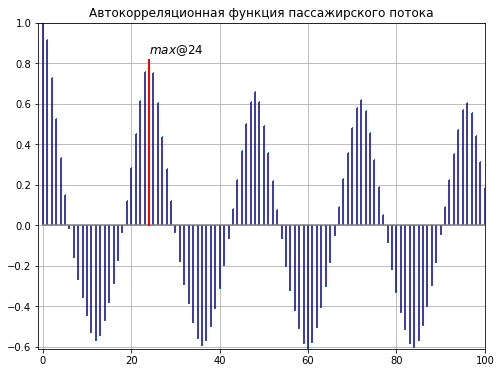

In [41]:
custom_plot_acf(traffic_data['traffic_volume'][:1000], lags=100, color='darkblue', title='Автокорреляционная функция пассажирского потока')

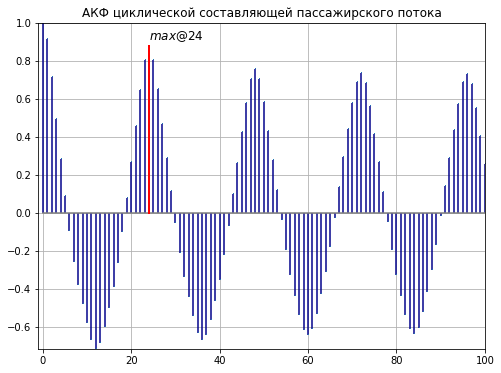

In [42]:
custom_plot_acf(traffic_uc_result.seasonal.smoothed, lags=100, color='darkblue', title='АКФ циклической составляющей пассажирского потока')

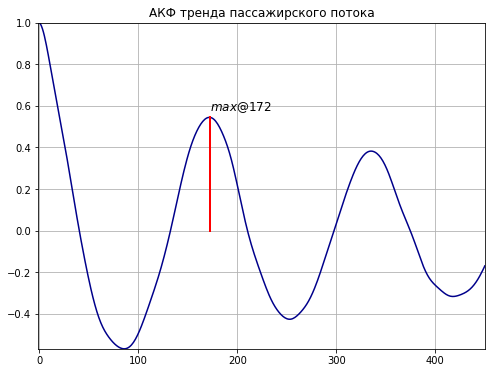

In [43]:
custom_plot_acf(traffic_uc_result.level.smoothed, lags=450, color='darkblue', style='line', title='АКФ тренда пассажирского потока')

#### Положение максимумов автокорреляционной функции позволяет оценить значение периода временного ряда.
#### Предположения, основанные на визуальном анализе, подтверждаются аналитически: #### максимумы АКФ
#### компонент пассажирского трафика соответствуют <b>суточной</b> ($24$ часа) и <b>недельной</b> ($172\approx168=24\times7$ часов) периодичности,
#### соответственно, для циклическо составляющей и тренда.

In [44]:
sm.tsa.stattools.adfuller(traffic_data['traffic_volume'])[1]

0.0

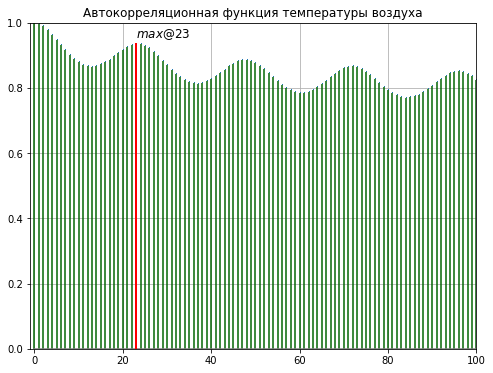

In [45]:
custom_plot_acf(temperature_data['temp'], lags=100, color='darkgreen', title='Автокорреляционная функция температуры воздуха')

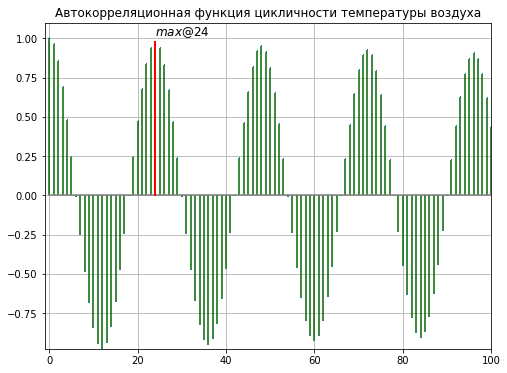

In [46]:
custom_plot_acf(temperature_uc_result.seasonal.smoothed, lags=100, color='darkgreen', title='Автокорреляционная функция цикличности температуры воздуха')

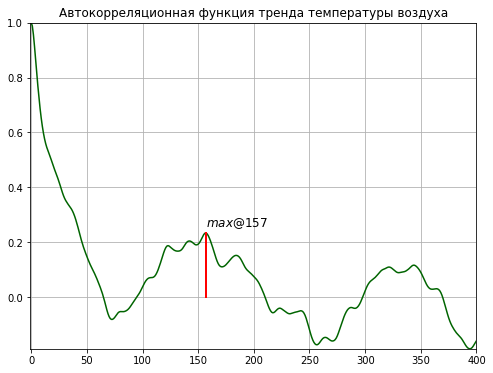

In [47]:
custom_plot_acf(temperature_uc_result.level.smoothed, lags=400, color='darkgreen', style='line', title='Автокорреляционная функция тренда температуры воздуха')

In [48]:
sm.tsa.stattools.adfuller(temperature_data['temp'])[1]

6.454259655955463e-06

#### Положение максимумов АКФ ряда тмпературы воздуха также подтверждает наличие суточного цикла (24 часа).
#### Наличие локального максимума АКФ тренда вблизи значения 168 вряд ли можно расценивать как подтверждение
#### наличия недельного цикла температуры. Максимум не такой выраженный, как в случае пассажирского трафика,
#### сама АКФ не имеет периодичности. На сам факт отмечаем.

## <a id='20'>2. Построение моделей прогнозирования</a>

### <a id='21'>2.1 Подбор параметров модели SARIMAX</a>

In [49]:
slice_start_index = 11172
slice_length = 24*7*2

traffic_slice = traffic_data['traffic_volume'][slice_start_index : slice_start_index + slice_length]
temperature_slice = temperature_data['temp'][slice_start_index : slice_start_index + slice_length]

#### Из набора данных возьмём произвольную выборку объёмом 336 отсчётов.
#### И на ней предварительно оценим параметры модели - степень интегрированности временного ряда,
#### параметры моделей авторегрессии и экспоненциального сглаживания.

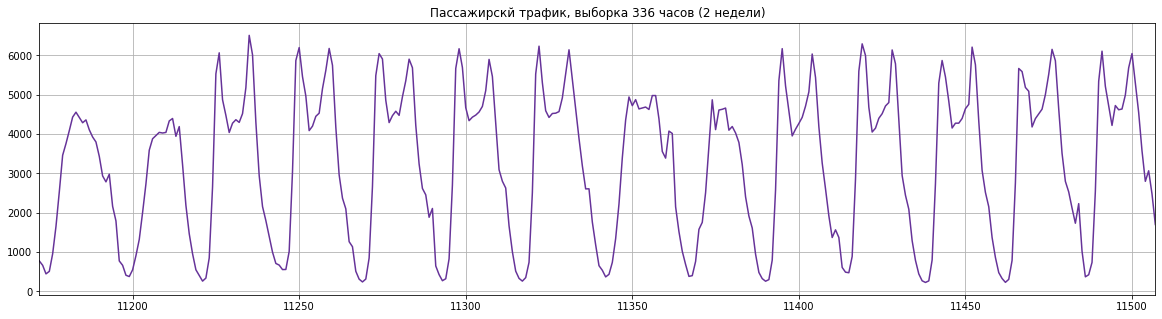

In [50]:
traffic_slice.plot(color='rebeccapurple', figsize=(20,5), grid=True, title='Пассажирскй трафик, выборка 336 часов (2 недели)');

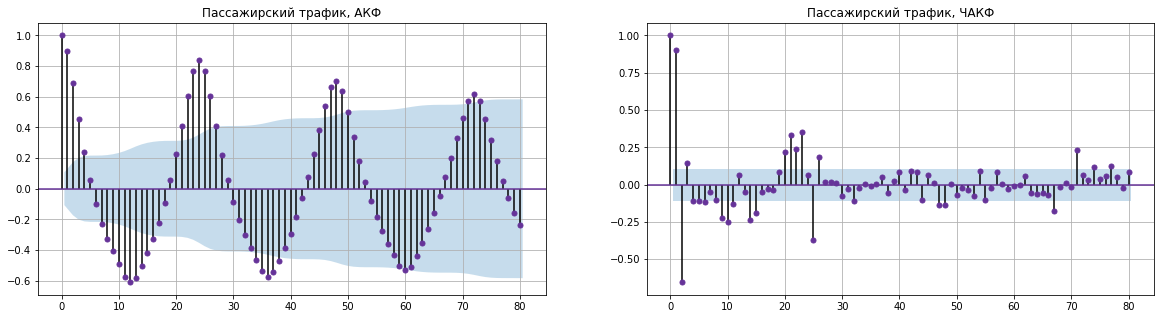

In [51]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20,5))
tsa.plot_acf(traffic_slice, lags=80, color='rebeccapurple', ax=ax[0], title='Пассажирский трафик, АКФ');
ax[0].grid()
tsa.plot_pacf(traffic_slice, lags=80, color='rebeccapurple', ax=ax[1], title='Пассажирский трафик, ЧАКФ');
ax[1].grid()

In [52]:
sm.tsa.stattools.adfuller(traffic_slice)[1]

9.597593358471459e-17

#### Значение p-value в тесте Дики-Фуллера позволяет отбросить гипотезу о нестационарности временного ряда.

In [53]:
traffic_day_diff = traffic_slice - traffic_slice.shift(periods=24)

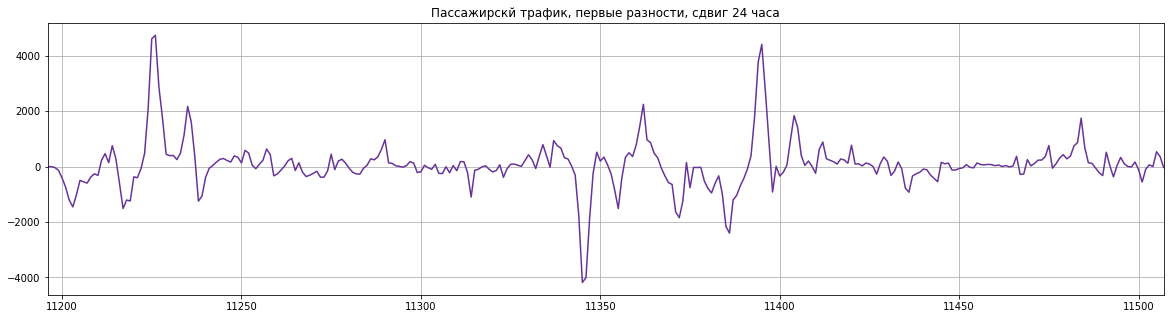

In [54]:
traffic_day_diff[24:].plot(color='rebeccapurple', figsize=(20,5), grid=True, title='Пассажирскй трафик, первые разности, сдвиг 24 часа');

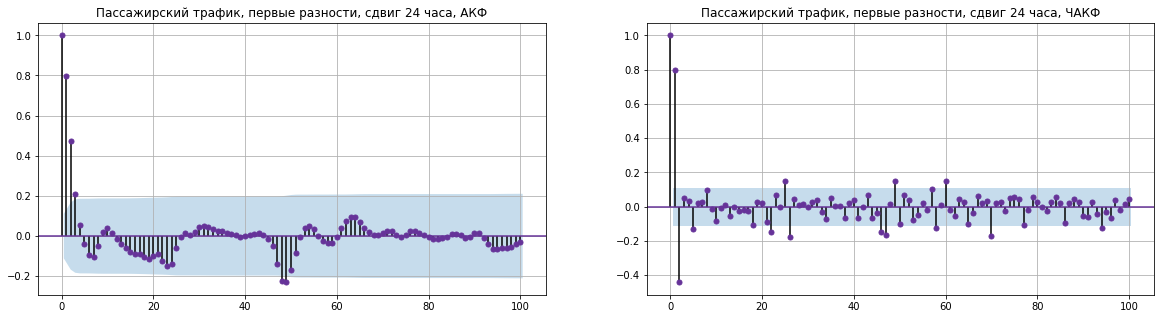

In [55]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20,5))
tsa.plot_acf(traffic_day_diff[24:], lags=100, color='rebeccapurple', ax=ax[0], title='Пассажирский трафик, первые разности, сдвиг 24 часа, АКФ');
ax[0].grid()
tsa.plot_pacf(traffic_day_diff[24:], lags=100, color='rebeccapurple', ax=ax[1], title='Пассажирский трафик, первые разности, сдвиг 24 часа, ЧАКФ');
ax[1].grid()

In [56]:
sm.tsa.stattools.adfuller(traffic_day_diff[24:])[1]

1.0122586987237243e-14

#### После "сезонного дифференциирования" пропадает выраженная периодичность и временного ряда, и АКФ.

In [57]:
traffic_day_2diff = traffic_day_diff - traffic_day_diff.shift(periods=1)

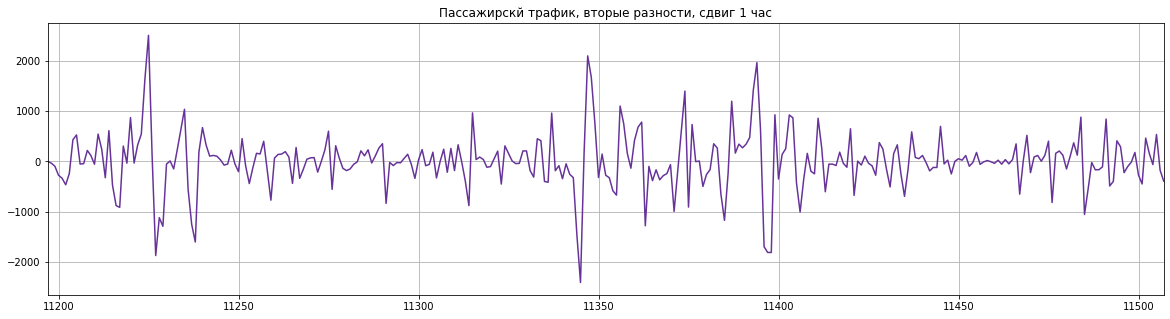

In [58]:
traffic_day_2diff[25:].plot(color='rebeccapurple', figsize=(20,5), grid=True, title='Пассажирскй трафик, вторые разности, сдвиг 1 час');

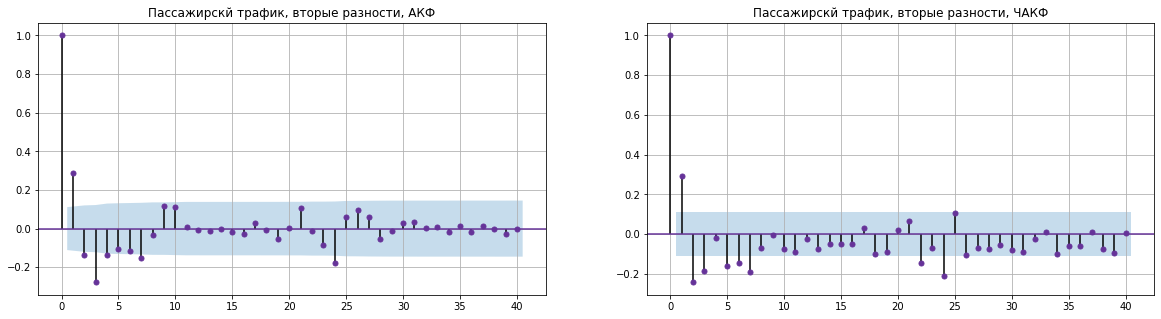

In [59]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20,5))
tsa.plot_acf(traffic_day_2diff[25:], lags=40, color='rebeccapurple', ax=ax[0], title='Пассажирскй трафик, вторые разности, АКФ');
ax[0].grid()
tsa.plot_pacf(traffic_day_2diff[25:], lags=40, color='rebeccapurple', ax=ax[1], title='Пассажирскй трафик, вторые разности, ЧАКФ');
ax[1].grid()

In [60]:
sm.tsa.stattools.adfuller(traffic_day_2diff[25:])[1]

2.6915990044778803e-19

#### АКФ и частная АКФ ПЕРВОЙ производной пассажирского трафика статистически не значимы временные лаги после 2-го - 3-го.
#### Поэтому порядок интегрированности пассажирского трафика примем равным 1.

In [61]:
from itertools import product

In [62]:
ps = range(2, 5)
d = 1 
qs = range(2, 5)
Ps = range(0, 2)
D = 1 
Qs = range(0, 2)
s = 24

parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

36

In [63]:
forecast_length = 24

In [64]:
traffic_frcst_reference = traffic_data['traffic_volume'][slice_start_index + slice_length : slice_start_index + slice_length + forecast_length]

#### Остальные параметры модели SARIMAX подберём, выбрав комбинацию, приводящую к минимиуму ошибки предсказания.

In [65]:
def optimizeSARIMA(train_data, test_data, parameters_list, d, D, s):
    """
        Return dataframe with parameters and corresponding AIC
        
        parameters_list - list with (p, q, P, Q) tuples
        d - integration order in ARIMA model
        D - seasonal integration order 
        s - length of season
    """
    
    results = []
    best_aic = float("inf")

    for param in parameters_list:        
        try:
            model=sm.tsa.statespace.SARIMAX(
                train_data,
                order=(param[0], d, param[1]),
                seasonal_order=(param[2], D, param[3], s)
            ).fit(disp=False)
        except:
            continue
        aic = model.aic
        forecast = model.get_forecast(steps=len(test_data)).predicted_mean        
        mape = mean_absolute_percentage_error(test_data, forecast)
        # saving best model, AIC and parameters
        if aic < best_aic:
            best_model = model
            best_aic = aic
            best_param = param
        results.append([param, model.aic, mape])

    result_table = pd.DataFrame(results)
    result_table.columns = ['parameters', 'aic', 'mape']
    # sorting in ascending order, the lower AIC is - the better
    result_table = result_table.sort_values(by='mape', ascending=True).reset_index(drop=True)
    
    return result_table

In [66]:
%%time
#result_table = optimizeSARIMA(traffic_slice, traffic_frcst_reference, parameters_list, d, D, s)

Wall time: 0 ns


In [67]:
#result_table.to_pickle('traffic_sarima_optimization_results.pkl')
result_table = pd.read_pickle('traffic_sarima_optimization_results.pkl')

In [68]:
result_table.head(10).style.highlight_min()

,parameters,aic,mape
0,"(3, 4, 1, 0)",4725.27,66.011
1,"(4, 2, 0, 1)",4712.45,66.5334
2,"(3, 2, 0, 1)",4710.13,66.5427
3,"(3, 4, 0, 1)",4714.09,66.7492
4,"(2, 2, 0, 1)",4708.77,66.8392
5,"(2, 4, 0, 0)",4733.86,66.8553
6,"(3, 2, 1, 0)",4721.81,66.8558
7,"(2, 3, 0, 0)",4735.48,66.9307
8,"(3, 3, 0, 1)",4711.04,67.0189
9,"(2, 4, 1, 0)",4722.48,67.0206


#### Результаты перебора парметров представлены в таблице.
#### Минимум средней абсолютной ошибки в процентах достигается при параметрах p=3, q=4, P=1, Q=0.
#### Проведём обучение модели и оценим точность прогноза.

In [69]:
traffic_sarimax_model=sm.tsa.statespace.SARIMAX(
    endog=traffic_slice,
    order=(3,1,4),
    seasonal_order=(1, 1, 0, 24)
).fit(disp=True)

C:\Users\Supervisor\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [70]:
traffic_sarimax_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                     traffic_volume   No. Observations:                  336
Model:             SARIMAX(3, 1, 4)x(1, 1, 0, 24)   Log Likelihood               -2353.635
Date:                            Wed, 11 Dec 2019   AIC                           4725.270
Time:                                    10:40:17   BIC                           4758.928
Sample:                                         0   HQIC                          4738.724
                                            - 336                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.3790      0.342      4.029      0.000       0.708       2.050
ar.L2         -0.3386      0.490     -0.691      0.490      -1.300       0.623
ar.L3         -0.0822      0.210     -0.391      0.696      -0.495       0.330
ma.L1         -1.1786      0.334     -3.531      0.000      -1.833      -0.524
ma.L2         -0.2231      0.446     -0.500      0.617      -1.097       0.651
ma.L3          0.1080      0.139      0.775      0.439      -0.165       0.381
ma.L4          0.2940      0.127      2.320      0.020       0.046       0.542
ar.S.L24      -0.2239      0.055     -4.083      0.000      -0.331      -0.116
sigma2      2.188e+05    1.7e+04     12.906      0.000    1.86e+05    2.52e+05
===================================================================================
Ljung-Box (Q):                       23.61   Jarque-Bera (JB):               187.89
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               0.65   Skew:                             0.21
Prob(H) (two-sided):                  0.03   Kurtosis:                         6.78
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [71]:
forecast_length = 24

In [72]:
traffic_forecast = traffic_sarimax_model.get_forecast(steps=forecast_length).predicted_mean

In [73]:
traffic_frcst_reference = traffic_data['traffic_volume'][slice_start_index + slice_length : slice_start_index + slice_length + forecast_length]

In [74]:
traffic_prediction_mape = mean_absolute_percentage_error(traffic_frcst_reference, traffic_forecast)

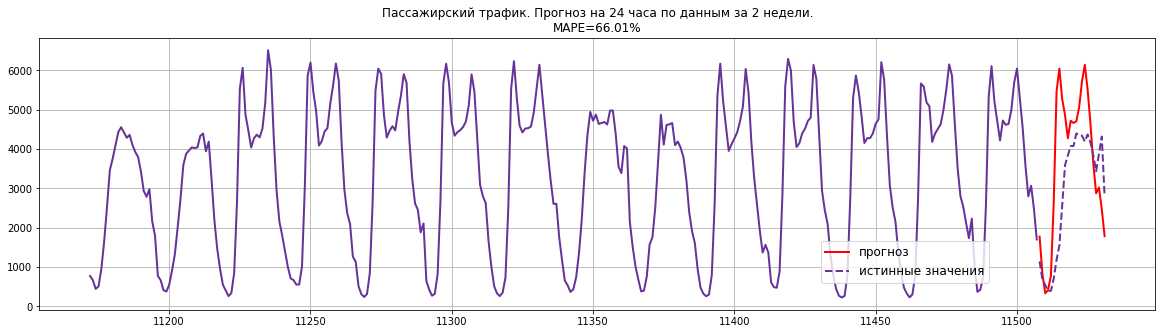

In [75]:
fig, ax = plt.subplots(figsize=(20,5))
ax.plot(traffic_slice, color='rebeccapurple', lw=2)
ax.plot(traffic_forecast, color='r', ls='-', lw=2, label='прогноз');
ax.plot(traffic_frcst_reference, color='rebeccapurple', lw=2, ls='dashed', label='истинные значения');

ax.set_title(f'Пассажирский трафик. Прогноз на 24 часа по данным за 2 недели.\nMAPE={traffic_prediction_mape:.2f}%', fontsize=12);
ax.grid()
ax.legend(fontsize=12, loc=(.7,.1));

#### Средняя абсолютная ошибка предсказания для данной выборки составила 66%. Это очень много.

<div class='alert alert-block alert-warning'>Попробуем оптимизировать модель.</div>

### <a id='22'>2.2 Раздельное прогнозирование тренда и периодической составляющей</a>

#### Предыдущая модель не "уловила" снижение трафика в выходные дни.
#### Для оптимизации предлагается такой подход:
#### с помощью модели SARIMAX предсказывать тренд трафика, как медленно меняющуюяся компоненту,
#### а для предсказазния циклической составляющей использовать просто усреднённые
#### по нескольким циклам значения, отстоящие друг от друга на один период - в нашем случае 168 часов (неделя).
#### Другими словами, предлагается выделить во временном ряде тренд и циклическую составляющую,
#### построить "усреднённый период" для циклической оставляющей и использовать его как прогноз,
#### а тренд прогнозировать моделью SARIMAX.

<div class='alert alert-block alert-warning'>Т.е. прогнозировать тренд и цклическую составляющую по-отдельности.</div>

In [76]:
slice_start_index = 100
slice_length = 24*30

traffic_trend_slice = pd.Series(traffic_uc_result.level.smoothed[slice_start_index : slice_start_index + slice_length])

#### Берём выборку значенийц тренда, выделенного ранее моделью UnobservedComponents.

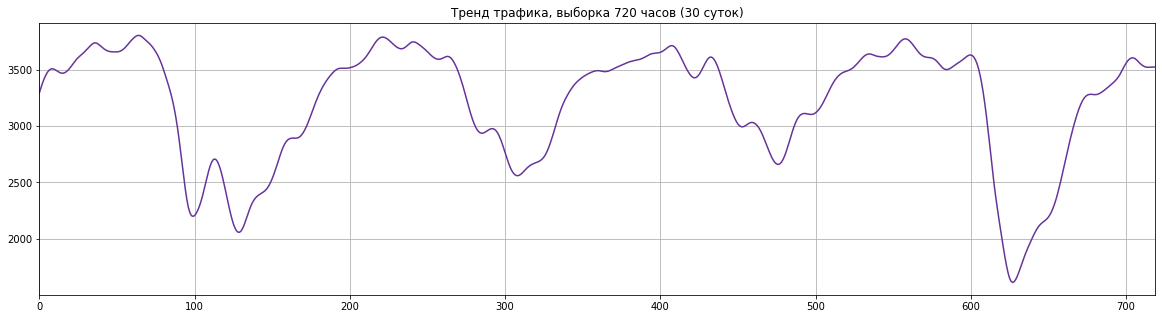

In [77]:
traffic_trend_slice.plot(color='rebeccapurple', figsize=(20,5), grid=True, title='Тренд трафика, выборка 720 часов (30 суток)');

C:\Users\Supervisor\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1358: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


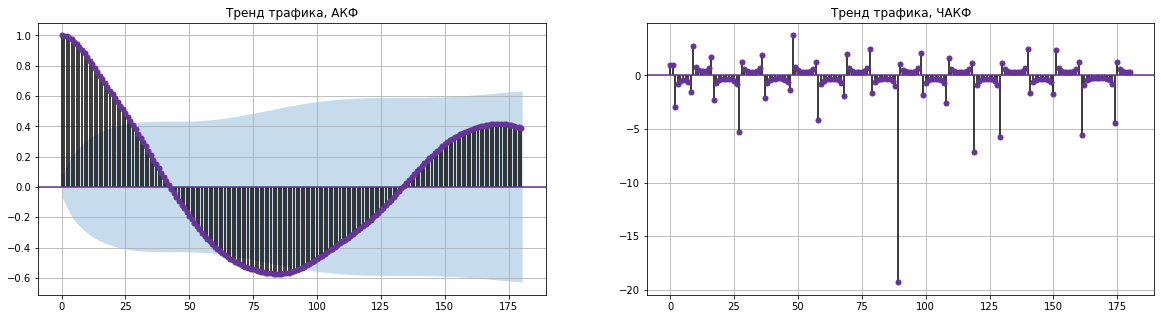

In [78]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20,5))
tsa.plot_acf(traffic_trend_slice, lags=180, color='rebeccapurple', ax=ax[0], title='Тренд трафика, АКФ');
ax[0].grid()
tsa.plot_pacf(traffic_trend_slice, lags=180, color='rebeccapurple', ax=ax[1], title='Тренд трафика, ЧАКФ');
ax[1].grid()

In [79]:
sm.tsa.stattools.adfuller(traffic_trend_slice)[1]

0.00044264734824097827

In [80]:
traffic_trend_day_diff = traffic_trend_slice - traffic_trend_slice.shift(periods=1)

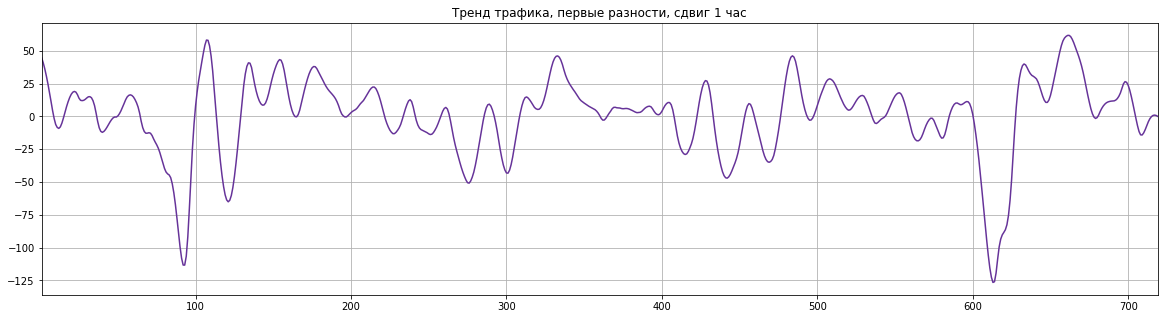

In [81]:
traffic_trend_day_diff[1:].plot(color='rebeccapurple', figsize=(20,5), grid=True, title='Тренд трафика, первые разности, сдвиг 1 час');

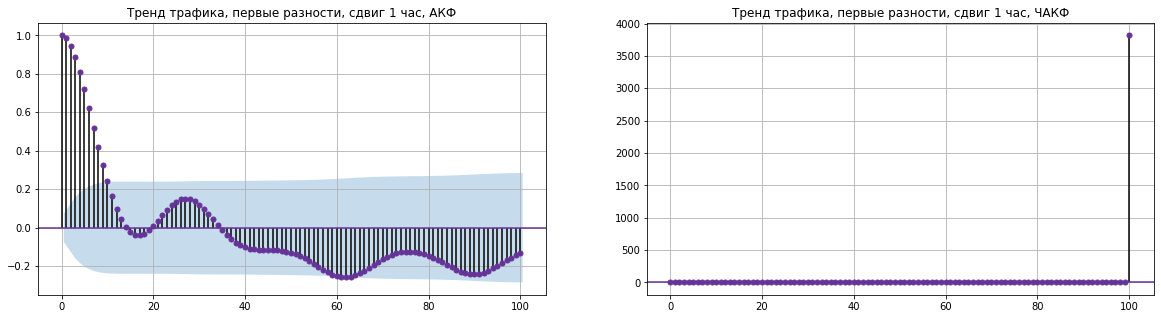

In [82]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20,5))
tsa.plot_acf(traffic_trend_day_diff[1:], lags=100, color='rebeccapurple', ax=ax[0], title='Тренд трафика, первые разности, сдвиг 1 час, АКФ');
ax[0].grid()
tsa.plot_pacf(traffic_trend_day_diff[1:], lags=100, color='rebeccapurple', ax=ax[1], title='Тренд трафика, первые разности, сдвиг 1 час, ЧАКФ');
ax[1].grid()

In [83]:
sm.tsa.stattools.adfuller(traffic_trend_day_diff[1:])[1]

7.951946202074312e-05

#### Вид АКФ и частной АКФ первой производной ТРЕНДА пассажирского трафика, а также значение p-value в тесте Дики-Фуллера позволяют считать этот ряд стационарным.
#### Поэтому порядок интегрированности ТРЕНДА пассажирского трафика также примем равным 1.

In [84]:
forecast_length = 72

In [85]:
traffic_trend_frcst_reference = traffic_uc_result.level.smoothed[slice_start_index + slice_length : slice_start_index + slice_length + forecast_length]

In [86]:
ps = range(2, 5)
d = 1 
qs = range(2, 5)
Ps = range(0, 2)
D = 1 
Qs = range(0, 2)
s = 24

parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

36

In [88]:
#%%time
#result_table = optimizeSARIMA(traffic_trend_slice, traffic_trend_frcst_reference, parameters_list, d, D, s)

In [89]:
#result_table.to_pickle('traffic_trend_sarima_optimization_results.pkl')
result_table = pd.read_pickle('traffic_trend_sarima_optimization_results.pkl')

#### Также перебором параметров найдём их сочетание, дающее минимальную ошибку предсказания.

In [90]:
result_table.head(10).style.highlight_min()

,parameters,aic,mape
0,"(2, 2, 1, 0)",1350.91,4.41055
1,"(2, 3, 1, 0)",1207.5,4.57259
2,"(2, 4, 1, 0)",1154.17,4.75283
3,"(4, 2, 1, 0)",1121.1,4.86976
4,"(2, 2, 0, 1)",1196.7,4.8974
5,"(4, 3, 1, 0)",1122.85,4.94444
6,"(4, 4, 1, 0)",1124.83,4.96248
7,"(2, 4, 0, 1)",1001.48,5.06508
8,"(2, 3, 0, 1)",1046.74,5.07325
9,"(4, 3, 0, 1)",965.74,5.30404


In [91]:
traffic_trend_sarimax_model=sm.tsa.statespace.SARIMAX(
    endog=traffic_trend_slice,
    order=(2,1,2),
    seasonal_order=(1, 1, 0, 24)
).fit(disp=True)

C:\Users\Supervisor\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:961: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


In [92]:
traffic_trend_sarimax_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  720
Model:             SARIMAX(2, 1, 2)x(1, 1, 0, 24)   Log Likelihood                -669.453
Date:                            Wed, 11 Dec 2019   AIC                           1350.907
Time:                                    10:41:17   BIC                           1378.170
Sample:                                         0   HQIC                          1361.449
                                            - 720                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.9260      0.009    224.294      0.000       1.909       1.943
ar.L2         -0.9484      0.008   -114.827      0.000      -0.965      -0.932
ma.L1          1.2375      0.027     46.356      0.000       1.185       1.290
ma.L2          0.5871      0.027     21.864      0.000       0.534       0.640
ar.S.L24      -0.3829      0.029    -13.025      0.000      -0.440      -0.325
sigma2         0.3914      0.017     22.424      0.000       0.357       0.426
===================================================================================
Ljung-Box (Q):                      352.66   Jarque-Bera (JB):                96.19
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.00   Skew:                             0.28
Prob(H) (two-sided):                  0.99   Kurtosis:                         4.74
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [93]:
traffic_trend_forecast = traffic_trend_sarimax_model.get_forecast(steps=forecast_length).predicted_mean

In [94]:
traffic_trend_prediction_mape = mean_absolute_percentage_error(traffic_trend_frcst_reference, traffic_trend_forecast)

#### Обучаем модель и строим прогноз тренда пассажирского трафика на 72 часа.

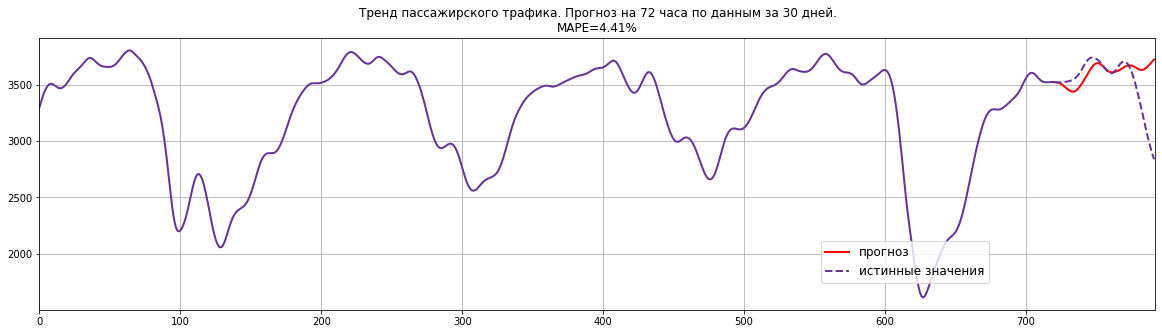

In [95]:
fig, ax = plt.subplots(figsize=(20,5))
ax.plot(traffic_trend_slice, color='rebeccapurple', lw=2)
ax.plot(traffic_trend_forecast, color='r', ls='-', lw=2, label='прогноз');
ax.plot(
    range(len(traffic_trend_slice), len(traffic_trend_slice) + forecast_length),
    traffic_trend_frcst_reference, color='rebeccapurple', lw=2, ls='dashed', label='истинные значения'
);

ax.set_title(f'Тренд пассажирского трафика. Прогноз на 72 часа по данным за 30 дней.\nMAPE={traffic_trend_prediction_mape:.2f}%', fontsize=12);
ax.grid()
ax.legend(fontsize=12, loc=(.7,.1));
ax.set_xlim([0,len(traffic_trend_slice) + forecast_length]);

<div class='alert alert-block alert-warning'>
    <p>Ошибка предсказания тренда оказалась значительно ниже, чем полного ряда!</p>
    <p><b>4,5%</b> вместо 66-ти.</p>
</div>

#### Т.е., возможно, предсказывать тренд можно более точно, чем полный ряд, и это повысит точность прогноза.
#### Для проверки этой гипотезы предлагается такая оптимизация.
#### Обучение модели UnobservedComponents - довольно длительная процедура. Пр этом, результат выделения ей тренда
#### близок ктому, что даёт простое сглаживание скользщим окном.
#### Поэтому для экономи времени разделение полного ряда на тренд и циклическую составляющую предлагается
#### производить именно сглаживанием - для плучения тренда  вычитанием из полного ряда сглаженного тренда -
#### для получения периодической составляющей.
#### Т.е. мы принимаем гипотезу об аддитивности тренда.

In [96]:
# разделение временного ряда на две составляющие - тренд и циклическая составляющая
def get_trend_seasonal_components(data, season_length, smoothing_size):
    data_length = len(data)
    assert len(data) >= 2 * season_length
    
    data_trend = np.zeros(data_length)
    # идём с конца ряда, усредняем значения в интервале smoothing size
    idx = data_length - 1
    while idx - smoothing_size >= -1:
        data_trend[idx] = np.mean(data[idx - smoothing_size + 1 : idx + 1])
        idx -= 1
    # останавливаемся на отсчёте, отстоящем от конца на season_length
    stop_idx = idx
    # идём с начала ряда к концу до того отсчёта, на котором остановились в первом цикле
    idx = 0
    while idx <= stop_idx:
        data_trend[idx] = np.mean(data[idx : idx + smoothing_size])
        idx += 1
    trend_delta = data_trend[idx] - data_trend[idx-1]
    idx = 0
    while idx <= stop_idx:
        data_trend[idx] += trend_delta
        idx += 1
    # теперь у нас есть сглаженные значения для всех отсчётов - это и есть наш тренд
    
    # вычисляем циклическую компоненту как разность исходного ряда и тренда
    data_seasonal = data - data_trend    
    
    # получаем усреднённый цикл - усредняем значения циклической составляющей, отстоящие на season_length, по целому числу циклов ОТ КОНЦА
    average_season_period = np.zeros(season_length)
    start_idx = data_length % season_length
    season_count = data_length // season_length
    for idx in range(season_length):
        sum = 0
        for season_idx in range(season_count):
            sum += data_seasonal[start_idx + idx + season_idx * season_length]
        average_season_period[idx] = sum / season_count
    # повторяем период season_count раз
    average_data_seasonal = np.zeros(data_length)
    average_data_seasonal[start_idx:] = np.tile(average_season_period, season_count)
    if start_idx > 0:
        average_data_seasonal[:start_idx] = average_season_period[-start_idx:]
    
    return data_trend, data_seasonal, average_data_seasonal

In [97]:
d_tr, d_ssn, d_avs = get_trend_seasonal_components(traffic_data['traffic_volume'].values[-720:], 24*7, 24)

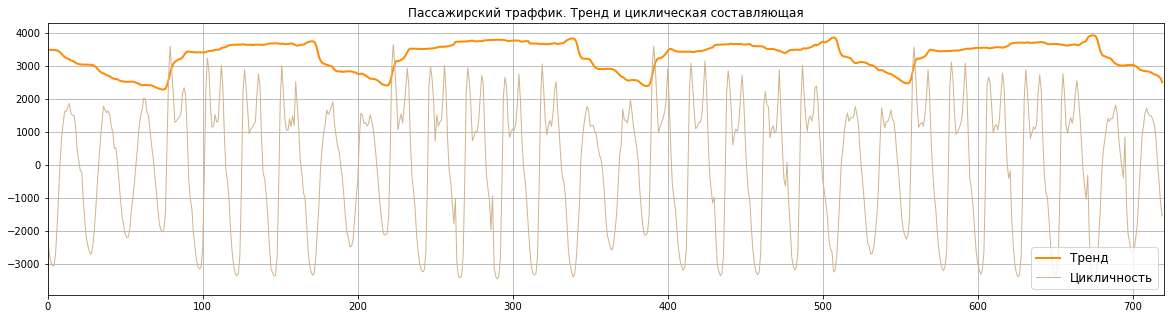

In [98]:
fig, ax = plt.subplots(figsize=(20,5))
ax.plot(d_tr, linestyle='solid', color ='darkorange', lw=2, label='Тренд')
ax.plot(d_ssn, linestyle='solid', color ='tan', lw=1, label='Цикличность')

ax.grid();
ax.set_xlim([0,len(d_tr)])
ax.legend(loc='lower right', fontsize=12);
ax.set_title('Пассажирский траффик. Тренд и циклическая составляющая');

#### Результат разделения ряда на тренд и циклическую составляющую представлен выше.
#### Оценим ошибку моделирования циклической оставляющей её "усреднённым циклом".

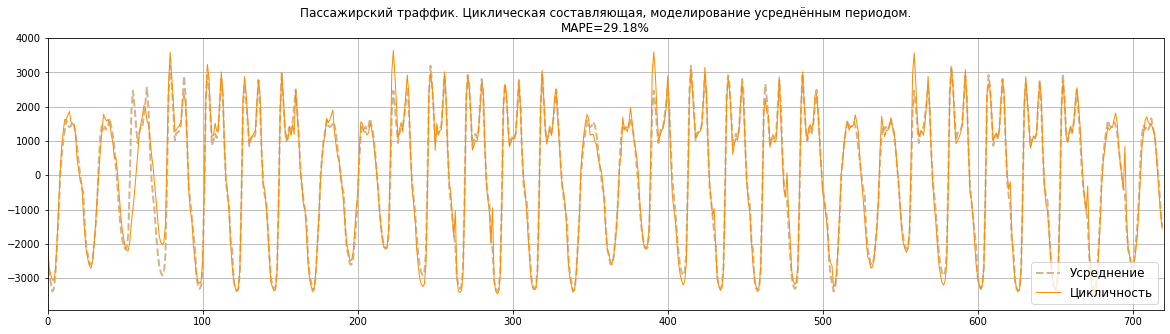

In [99]:
fig, ax = plt.subplots(figsize=(20,5))
ax.plot(d_avs, linestyle='dashed', color ='tan', lw=2, label='Усреднение')
ax.plot(d_ssn, linestyle='solid', color ='darkorange', lw=1, label='Цикличность')

ax.grid();
ax.set_xlim([0,len(d_avs)])
ax.legend(loc='lower right', fontsize=12);
ax.set_title(f'Пассажирский траффик. Циклическая составляющая, моделирование усреднённым периодом.\nMAPE={mean_absolute_percentage_error(d_avs, d_ssn):.02f}%');

#### На графике совмещены циклическая составляющая и состыкованные копии усреднённого цикла.
#### Средняя абсолютная ошибка моделирования высока - почти 30%.
#### Далее оценим ошибку прогнозирования.

In [100]:
def trend_seasonal_forecast(data, season_length, smoothing_size, SARIMAX_order, SARIMAX_seasonal_order, forecast_length):
    trend, _, average_seasonal = get_trend_seasonal_components(data, season_length, smoothing_size)
    
    sarimax_model = sm.tsa.statespace.SARIMAX(
        endog=trend,
        order=SARIMAX_order,
        seasonal_order=SARIMAX_seasonal_order
    ).fit(disp=False)
    
    trend_forecast = sarimax_model.get_forecast(steps=forecast_length).predicted_mean
    
    season_start_index = len(data) % season_length
    seasonal_forecast = average_seasonal[season_start_index : season_start_index + forecast_length]
    
    return trend_forecast, seasonal_forecast

In [101]:
slice_start_index = 100
slice_length = 24*30

forecast_length = 72

traffic_slice = traffic_data['traffic_volume'].values[slice_start_index : slice_start_index + slice_length]

In [102]:
traffic_forecast_reference = traffic_data['traffic_volume'].values[slice_start_index + slice_length : slice_start_index + slice_length + forecast_length]

In [103]:
traffic_trend_forecast, traffic_seasonal_forecast = trend_seasonal_forecast(traffic_slice, 24*7, 24, (2,1,2), (1, 1, 0, 24), forecast_length)

In [104]:
traffic_forecast = traffic_trend_forecast + traffic_seasonal_forecast

In [105]:
traffic_prediction_mape = mean_absolute_percentage_error(traffic_forecast_reference, traffic_forecast)

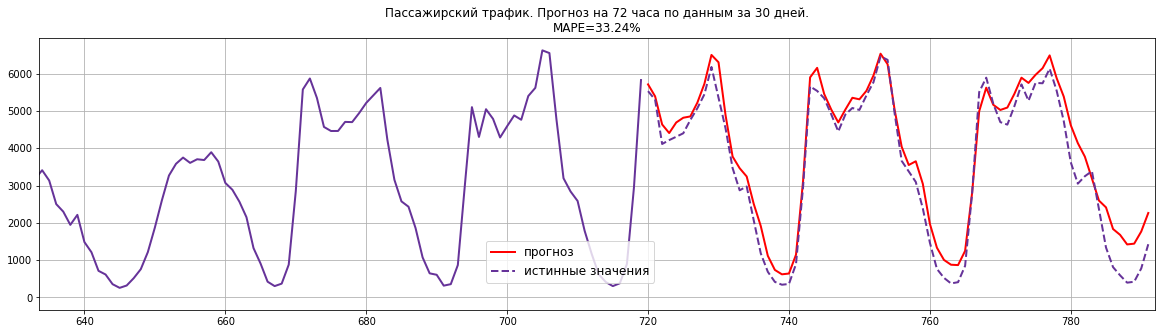

In [106]:
fig, ax = plt.subplots(figsize=(20,5))
ax.plot(traffic_slice, color='rebeccapurple', lw=2)
ax.plot(range(len(traffic_slice), len(traffic_slice) + forecast_length),
    traffic_forecast, color='r', ls='-', lw=2, label='прогноз'
);
ax.plot(
    range(len(traffic_slice), len(traffic_slice) + forecast_length),
    traffic_forecast_reference, color='rebeccapurple', lw=2, ls='dashed', label='истинные значения'
);

ax.set_title(f'Пассажирский трафик. Прогноз на 72 часа по данным за 30 дней.\nMAPE={traffic_prediction_mape:.2f}%', fontsize=12);
ax.grid()
ax.legend(fontsize=12, loc=(.4,.1));
ax.set_xlim([0.8 * (len(traffic_trend_slice) + forecast_length), len(traffic_trend_slice) + forecast_length]);

#### В случае раздельного прогнозирования тренда и периодической составляющей пассажирского трафика удалось получить меньшую ошибку,
#### чем в случае прогнозирования полного ряда. Но это - результат для конкретной выборки выборки.
#### Для достоверной оценки эффективности предложенного подхода далее проведём кросс-валидацию.

In [107]:
temperature_slice = temperature_data['temp'].values[slice_start_index : slice_start_index + slice_length]
temperature_forecast_reference = temperature_data['temp'].values[slice_start_index + slice_length : slice_start_index + slice_length + forecast_length]

In [108]:
t_tr, t_ssn, t_avs = get_trend_seasonal_components(temperature_slice, 24, 24)

In [109]:
temperature_trend_forecast, temperature_seasonal_forecast = trend_seasonal_forecast(temperature_slice, 24, 24, (2,1,2), (1, 1, 0, 24), forecast_length)

In [110]:
temperature_forecast = temperature_trend_forecast + temperature_seasonal_forecast

In [111]:
temperature_prediction_mape = mean_absolute_percentage_error(temperature_forecast_reference, temperature_forecast)

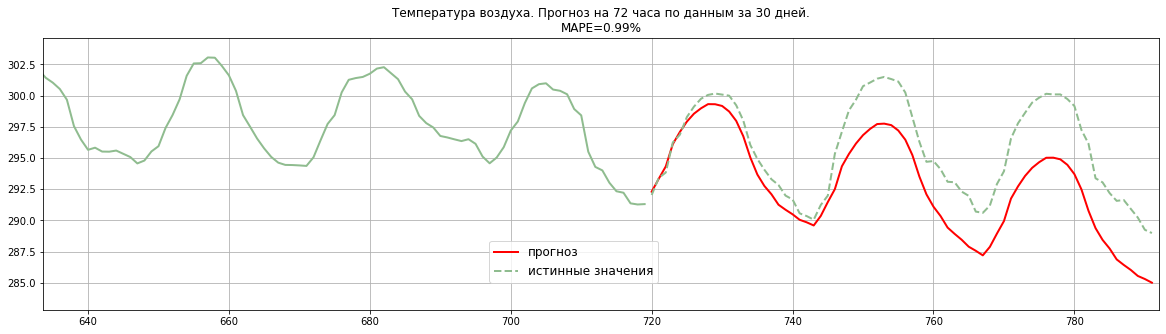

In [112]:
fig, ax = plt.subplots(figsize=(20,5))
ax.plot(temperature_slice, color='darkseagreen', lw=2)
ax.plot(range(len(temperature_slice), len(temperature_slice) + forecast_length),
    temperature_forecast, color='r', ls='-', lw=2, label='прогноз'
);
ax.plot(
    range(len(temperature_slice), len(temperature_slice) + forecast_length),
    temperature_forecast_reference, color='darkseagreen', lw=2, ls='dashed', label='истинные значения'
);

ax.set_title(f'Температура воздуха. Прогноз на 72 часа по данным за 30 дней.\nMAPE={temperature_prediction_mape:.2f}%', fontsize=12);
ax.grid()
ax.legend(fontsize=12, loc=(.4,.1));
ax.set_xlim([0.8 * (len(temperature_slice) + forecast_length), len(temperature_slice) + forecast_length]);

#### Точность прогноза температуры воздуха оказалась намного выше, чем точность прогноза количества пассажиров.

### <a id='23'>2.3 Перекрёстная проверка точности моделей прогнозирования SARIMAX</a>

In [113]:
import time
import progressbar

#### Предлагается следующая схема кросс-валидации:
#### 1) из полного временного ряда берётся случайная выборка случайной длительности
#### 2) на этой выборке оценивается ошибка прогнозирования
#### 3) ошибка усредняется по всем случайным выборкам.
#### Для длительности выборки установим диапазон от 2-ух до 4-ёх недель, чтобы модель могла "уловить"
#### периодичности тренда и циклической составляющей.
#### Кроме того, оценим связь точности прогноза и длительности тестовой выборки.

In [114]:
def cross_validate_sarimax_forecast(
    full_data, train_length_range,
    SARIMAX_order, SARIMAX_seasonal_order, forecast_length,
    cv=10, random_state=None
):
    '''
    Кросс-валидация модели SARIMAX
    Параметры:
        - full_data - набор данных, из которого берутся обучающая и тестовая выборки
        - train_length_range - кортеж или список из двух значений - минимальной и максимальной длины обучающей выборки
        - SARIMAX_order - кортеж параметров order модели statsmodel SARIMAX
        - SARIMAX_seasonal_order - кортеж параметров seasonal_order модели statsmodel SARIMAX
        - forecast_length - длительность прогноза
        - cv - количество итераций кросс-валидации
        - random_state - параметр для инициализации генератора случайных чисел
    '''
    if random_state is not None:
        np.random.seed(random_state)
        
    cv_results_dict = {'fold_start' : [], 'fold_length' : [], 'rmse' : [], 'mape' : []}
    for i in progressbar.progressbar(range(cv)):
        # размер обучающей выборки - случайное число из диапазона train_length_range
        fold_length = np.random.randint(low=train_length_range[0], high=train_length_range[1])
        # ограничиваем дапазон выбора начала обучающей выборки та, чтобы не выйти за пределы набора данных
        fold_start_range = (0, len(full_data) - fold_length - forecast_length)
        # выбираем случайным образом начало обучающей выборки
        fold_start = np.random.randint(low=fold_start_range[0], high=fold_start_range[1])
        
        # формируем обучающую и тестовую выборки; тестовая - продолжение обучающей, на ней будем проверять точность прогноза
        train_data = full_data[fold_start : fold_start + fold_length]
        test_data = full_data[fold_start + fold_length : fold_start + fold_length + forecast_length]
        
        # создаём и обучаем модель
        sarimax_model = sm.tsa.statespace.SARIMAX(
            endog=train_data,
            order=SARIMAX_order,
            seasonal_order=SARIMAX_seasonal_order
        ).fit(disp=False)
        
        # генерируем прогноз
        forecast_data = sarimax_model.get_forecast(steps=forecast_length).predicted_mean
        
        # оцениваем ошибки, сравнивая прогноз и тестовую выборку
        rmse = np.sqrt(mean_squared_error(test_data, forecast_data))
        mape = mean_absolute_percentage_error(test_data, forecast_data)
        
        # добавляем параметры и результаты итерации в общую таюлицу результатов
        cv_results_dict['fold_start'].append(fold_start)
        cv_results_dict['fold_length'].append(fold_length)
        cv_results_dict['rmse'].append(rmse)
        cv_results_dict['mape'].append(mape)
    
    return pd.DataFrame.from_dict(cv_results_dict)

In [115]:
def cross_validate_mixed_forecast(
    full_data, train_length_range, 
    season_length, smoothing_size,
    SARIMAX_order, SARIMAX_seasonal_order, forecast_length,
    cv=10, random_state=None
):
    if random_state is not None:
        np.random.seed(random_state)
        
    cv_results_dict = {'fold_start' : [], 'fold_length' : [], 'rmse' : [], 'mape' : []}
    for i in progressbar.progressbar(range(cv)):
        fold_length = np.random.randint(low=train_length_range[0], high=train_length_range[1])
        fold_start_range = (0, len(full_data) - fold_length - forecast_length)
        fold_start = np.random.randint(low=fold_start_range[0], high=fold_start_range[1])
        
        train_data = full_data[fold_start : fold_start + fold_length]
        test_data = full_data[fold_start + fold_length : fold_start + fold_length + forecast_length]
        
        trend_forecast, seasonal_forecast = trend_seasonal_forecast(
            train_data, season_length, smoothing_size,
            SARIMAX_order, SARIMAX_seasonal_order, forecast_length
        )
        
        forecast_data = trend_forecast + seasonal_forecast
        
        rmse = np.sqrt(mean_squared_error(test_data, forecast_data))
        mape = mean_absolute_percentage_error(test_data, forecast_data)
        
        cv_results_dict['fold_start'].append(fold_start)
        cv_results_dict['fold_length'].append(fold_length)
        cv_results_dict['rmse'].append(rmse)
        cv_results_dict['mape'].append(mape)
    
    return pd.DataFrame.from_dict(cv_results_dict)

In [116]:
#traffic_sarimax_cv_results_24 = cross_validate_sarimax_forecast(
#    traffic_data['traffic_volume'].values, (24*14, 24*30),
#    (3,1,4), (1, 1, 0, 24), 24,
#    cv=100, random_state=1812
#)

`100% (100 of 100) |######################| Elapsed Time: 0:39:32 Time:  0:39:32`

In [117]:
#traffic_sarimax_cv_results_24.to_pickle('./traffic_sarimax_cv_results_24.pkl')

In [118]:
traffic_sarimax_cv_results_24 = pd.read_pickle('./traffic_sarimax_cv_results_24.pkl')

In [119]:
traffic_sarimax_cv_results_24.head()

,fold_start,fold_length,rmse,mape
0,8247,683,921.981054,43.891096
1,11085,710,417.114609,12.369710
2,24576,659,233.243563,9.150420
3,3456,519,815.143890,20.998925
4,4597,673,845.704560,41.258962


In [120]:
traffic_sarimax_cv_results_24['mape'].describe()

count    100.000000
mean      37.571810
std       34.520992
min        4.240251
25%       15.248426
50%       29.963644
75%       53.262666
max      287.539532
Name: mape, dtype: float64

#### Средняя абсолютная ошибка прогнозирования полного ряда моделью SARIMAX составила 37,6%.
#### При этом обработка 100 выборок заняла 39 мин 32 с.

In [121]:
#traffic_mixed_cv_results_24 = cross_validate_mixed_forecast(
#    traffic_data['traffic_volume'].values, (24*14, 24*30),
#    24*7, 24,
#    (2,1,2), (1, 1, 0, 24), 24,
#    cv=100, random_state=1812
#)

`100% (100 of 100) |######################| Elapsed Time: 0:06:35 Time:  0:06:35`

In [122]:
#traffic_mixed_cv_results_24.to_pickle('./traffic_mixed_cv_results_24.pkl')

In [123]:
traffic_mixed_cv_results_24 = pd.read_pickle('./traffic_mixed_cv_results_24.pkl')

In [124]:
traffic_mixed_cv_results_24.head()

,fold_start,fold_length,rmse,mape
0,15139,385,298.641072,10.756752
1,6961,394,334.918175,10.066340
2,5452,448,201.767225,10.539199
3,20509,433,550.778128,14.836732
4,18221,613,320.687411,16.139286


In [125]:
traffic_mixed_cv_results_24['mape'].describe()

count    100.000000
mean      36.186058
std       46.273849
min        5.353064
25%       12.862118
50%       18.784832
75%       39.269956
max      279.087556
Name: mape, dtype: float64

#### Средняя абсолютная ошибка раздельного прогнозирования составила 36,2%.
#### При этом обработка 100 выборок заняла 6 мин 35 с.

<div class='alert alert-block alert-warning'>
    <p>Основной <b>вывод</b>: раздельное прогнозирование не повысило точность предсказания.</p>
    <p>Однако, удалось <b>существенно</b> сократить время выполнения прогноза.</p>
</div>

In [126]:
traffic_mixed_cv_results_24['rmse'].describe()

count     100.000000
mean      683.523005
std       580.444066
min       145.300880
25%       326.504758
50%       497.942397
75%       792.675348
max      3151.407851
Name: rmse, dtype: float64

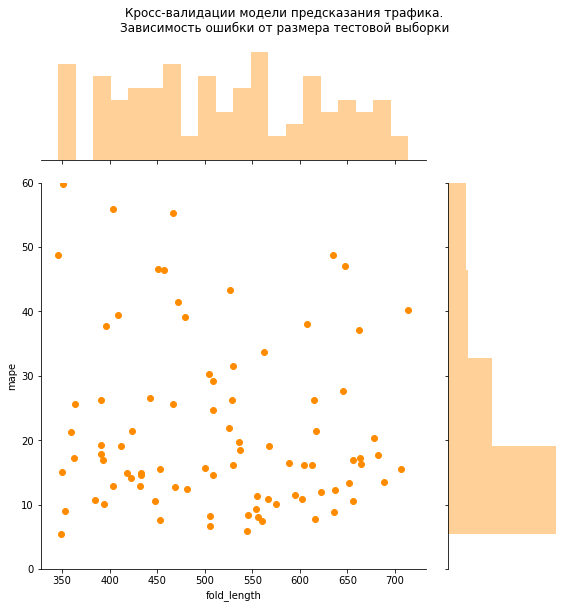

In [146]:
sns.jointplot(x='fold_length', y='mape', data=traffic_mixed_cv_results_24, ylim=(0,60), height=8, color='darkorange', ratio=3, marginal_kws={'bins':20}, );
plt.suptitle('Кросс-валидации модели предсказания трафика.\nЗависимость ошибки от размера тестовой выборки', x=0.5, y=1.05, fontsize=12);

#### Корреляции между длительность тестовой выборки и ошибкой предсказания не наблюдается.
#### Скорее всего, это означает, что выбранные длительности превосходят некую "критическую"
#### величину, на которой модель обеспечивает полученную точность, т.е. мы передавали модели избыточные данные.

### <a id='24'>2.4 Сравнение точностей предсказания температуры воздуха на 1 и 3 дня</a>

In [128]:
#temperature_mixed_cv_results_24 = cross_validate_mixed_forecast(
#    temperature_data['temp'].values, (24*14, 24*30),
#    24, 24,
#    (2,1,2), (1, 1, 0, 24), 24,
#    cv=100, random_state=1812
#)

`100% (100 of 100) |######################| Elapsed Time: 0:15:53 Time:  0:15:53`

In [129]:
#temperature_mixed_cv_results_24.to_pickle('./temperature_mixed_cv_results_24.pkl')

In [130]:
temperature_mixed_cv_results_24 = pd.read_pickle('./temperature_mixed_cv_results_24.pkl')

In [131]:
temperature_mixed_cv_results_24.head()

,fold_start,fold_length,rmse,mape
0,26607,690,7.553373,2.322944
1,9640,463,2.101326,0.619739
2,2591,622,5.118605,1.808159
3,7571,428,3.959524,1.248037
4,21591,395,7.518375,2.924216


In [132]:
temperature_mixed_cv_results_24['mape'].describe()

count    100.000000
mean       1.078514
std        0.703711
min        0.139224
25%        0.611044
50%        0.911523
75%        1.353529
max        4.663648
Name: mape, dtype: float64

#### Средее значение MAPE для прогнозов температуры воздуха на 24 часа составило 1%. Неплохой результат.

In [133]:
#temperature_mixed_cv_results_72 = cross_validate_mixed_forecast(
#    temperature_data['temp'].values, (24*14, 24*30),
#    24, 24,
#    (2,1,2), (1, 1, 0, 24), 72,
#    cv=100, random_state=1812
#)

`100% (100 of 100) |######################| Elapsed Time: 0:15:58 Time:  0:15:58`

In [134]:
#temperature_mixed_cv_results_72.to_pickle('temperature_mixed_cv_results_72.pkl')

In [135]:
temperature_mixed_cv_results_72 = pd.read_pickle('./temperature_mixed_cv_results_72.pkl')

In [136]:
temperature_mixed_cv_results_72.head()

,fold_start,fold_length,rmse,mape
0,11108,395,25.341785,7.127536
1,20155,449,10.526517,3.357086
2,382,365,2.345449,0.597456
3,9360,401,6.421090,1.828811
4,13567,416,2.638701,0.749098


In [137]:
temperature_mixed_cv_results_72['mape'].describe()

count    100.000000
mean       2.213247
std        1.627524
min        0.399598
25%        0.950914
50%        1.653853
75%        3.127696
max        7.181295
Name: mape, dtype: float64

#### Точность предсказания температауры на 3 дня вперёд оказалась вдвое хуже точности предсказания на 1 день.
#### Однако, само по себе среднее значение MAPE 2,2% говорит о высоком качестве модели.

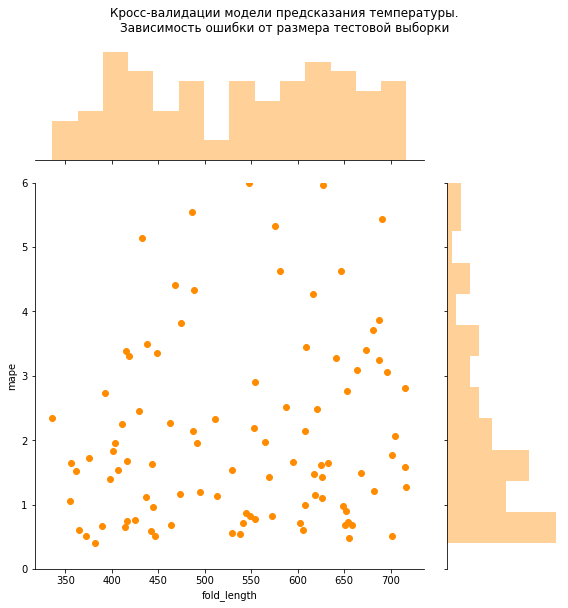

In [147]:
sns.jointplot(x='fold_length', y='mape', data=temperature_mixed_cv_results_72, ylim=(0,6), height=8, color='darkorange', ratio=3, marginal_kws={'bins':14});
plt.suptitle('Кросс-валидации модели предсказания температуры.\nЗависимость ошибки от размера тестовой выборки', x=0.5, y=1.05, fontsize=12);

#### Как и в случае кросс-валидации модели предсказания трафика, корреляции длительности обучающей выборки и ошибки предсказания не выявлено.

## <a id='25'>2.5 Тестирование модели Prophet от Facebook</a>

In [152]:
from fbprophet import Prophet

#### Для использования модели Prophet нужно подготовить данные - сформировать DataFrame в нужном формате.

In [153]:
traffic_fb_format_df = traffic_data.copy(deep=True)
traffic_fb_format_df['ds'] = interpolated_data.index
traffic_fb_format_df.columns = ['y', 'ds']
traffic_fb_format_df

,y,ds
0,352.0,2015-06-25 03:00:00
1,828.4,2015-06-25 04:00:00
2,1304.8,2015-06-25 05:00:00
3,1781.2,2015-06-25 06:00:00
4,2257.6,2015-06-25 07:00:00
...,...,...
28702,3543.0,2018-09-30 19:00:00
28703,2781.0,2018-09-30 20:00:00
28704,2159.0,2018-09-30 21:00:00
28705,1450.0,2018-09-30 22:00:00


In [154]:
slice_start_index = 100
slice_length = 24*30

forecast_length = 72

In [155]:
traffic_fb_slice = traffic_fb_format_df[slice_start_index : slice_start_index + slice_length]
traffic_fb_forecast_reference = traffic_fb_format_df[slice_start_index + slice_length : slice_start_index + slice_length + forecast_length]

#### Создаём и обучаем модель.

In [156]:
traffic_prophet_model = Prophet(
    yearly_seasonality=False,
    weekly_seasonality=True,
    daily_seasonality=True    
).fit(traffic_fb_slice)

In [157]:
traffic_prophet_future = traffic_prophet_model.make_future_dataframe(periods=72, freq='H', include_history=False)

In [158]:
traffic_prophet_forecast = traffic_prophet_model.predict(traffic_prophet_future)

In [159]:
traffic_prophet_prediction_mape = mean_absolute_percentage_error(traffic_fb_forecast_reference['y'].values, traffic_prophet_forecast['yhat'].values)

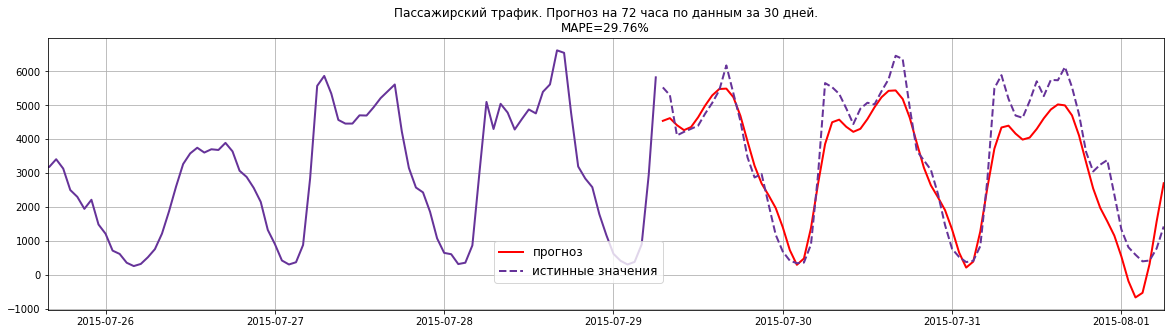

In [160]:
fig, ax = plt.subplots(figsize=(20,5))

ax.plot(
    traffic_fb_slice['ds'],
    traffic_fb_slice['y'], color='rebeccapurple', lw=2
)
ax.plot(
    traffic_prophet_forecast['ds'],
    traffic_prophet_forecast['yhat'], color='r', ls='-', lw=2, label='прогноз'
);
ax.plot(
    traffic_fb_forecast_reference['ds'], 
    traffic_fb_forecast_reference['y'], color='rebeccapurple', lw=2, ls='dashed', label='истинные значения'
);

ax.set_title(f'Пассажирский трафик. Прогноз на 72 часа по данным за 30 дней.\nMAPE={traffic_prophet_prediction_mape:.2f}%', fontsize=12);
ax.grid()
ax.legend(fontsize=12, loc=(.4,.1));
x_min = traffic_fb_slice['ds'].min()
x_max = traffic_prophet_forecast['ds'].max()
x_range = x_max - x_min
ax.set_xlim(xmin = x_min + 0.8*(x_max-x_min), xmax=x_max);
##print(x_max)
#ax.set_xlim(traffic_fb_slice['ds'].min(), traffic_prophet_forecast['ds'].max())

#### На этой же выборке средняя абсолютная ошибка прогнозирования раздельной модели SARIMAX была чуть больше - 33% процента против 29,8%.
#### Сравним модели после кросс-валидации.

#### Оценим качество модели Prophet и на прогнозе температуры воздуха.

In [161]:
temperature_fb_format_df = temperature_data.copy(deep=True)
temperature_fb_format_df['ds'] = interpolated_data.index
temperature_fb_format_df.columns = ['y', 'ds']
temperature_fb_format_df

,y,ds
0,291.0930,2015-06-25 03:00:00
1,291.9177,2015-06-25 04:00:00
2,292.7424,2015-06-25 05:00:00
3,293.5671,2015-06-25 06:00:00
4,294.3918,2015-06-25 07:00:00
...,...,...
28702,283.4500,2018-09-30 19:00:00
28703,282.7600,2018-09-30 20:00:00
28704,282.7300,2018-09-30 21:00:00
28705,282.0900,2018-09-30 22:00:00


In [162]:
slice_start_index = 100
slice_length = 24*30

forecast_length = 72

In [163]:
temperature_fb_slice = temperature_fb_format_df[slice_start_index : slice_start_index + slice_length]
temperature_fb_forecast_reference = temperature_fb_format_df[slice_start_index + slice_length : slice_start_index + slice_length + forecast_length]

In [164]:
temperature_prophet_model = Prophet(
    yearly_seasonality=False,
    weekly_seasonality=False,
    daily_seasonality=True    
).fit(temperature_fb_slice)

In [165]:
temperature_prophet_future = temperature_prophet_model.make_future_dataframe(periods=72, freq='H', include_history=False)

In [166]:
temperature_prophet_forecast = temperature_prophet_model.predict(temperature_prophet_future)

In [167]:
temperature_prophet_prediction_mape = mean_absolute_percentage_error(temperature_fb_forecast_reference['y'].values, temperature_prophet_forecast['yhat'].values)

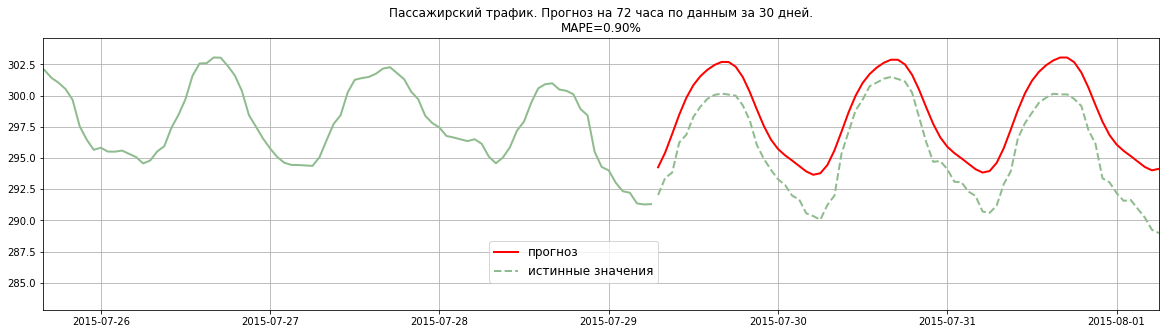

In [168]:
fig, ax = plt.subplots(figsize=(20,5))

ax.plot(
    temperature_fb_slice['ds'],
    temperature_fb_slice['y'], color='darkseagreen', lw=2
)
ax.plot(
    temperature_prophet_forecast['ds'],
    temperature_prophet_forecast['yhat'], color='r', ls='-', lw=2, label='прогноз'
);
ax.plot(
    temperature_fb_forecast_reference['ds'], 
    temperature_fb_forecast_reference['y'], color='darkseagreen', lw=2, ls='dashed', label='истинные значения'
);

ax.set_title(f'Пассажирский трафик. Прогноз на 72 часа по данным за 30 дней.\nMAPE={temperature_prophet_prediction_mape:.2f}%', fontsize=12);
ax.grid()
ax.legend(fontsize=12, loc=(.4,.1));
x_min = temperature_fb_slice['ds'].min()
x_max = temperature_prophet_forecast['ds'].max()
x_range = x_max - x_min
ax.set_xlim(xmin = x_min + 0.8*(x_max-x_min), xmax=x_max);
##print(x_max)
#ax.set_xlim(traffic_fb_slice['ds'].min(), traffic_prophet_forecast['ds'].max())

#### На этой выборке модели SARIMAX и Prophet показали очень близкие результаты - MAPE около 1%.
#### Для сравнения моделей проведём кросс-валидацию.

In [169]:
def cross_validate_prophet_forecast(
    full_data, train_length_range,    
    yearly_seasonality, weekly_seasonality, daily_seasonality,
    forecast_length,
    cv=10, random_state=None
):
    if random_state is not None:
        np.random.seed(random_state)
        
    cv_results_dict = {'fold_start' : [], 'fold_length' : [], 'rmse' : [], 'mape' : []}
    
    for i in progressbar.progressbar(range(cv)):
        fold_length = np.random.randint(low=train_length_range[0], high=train_length_range[1])
        fold_start_range = (0, len(full_data) - fold_length - forecast_length)
        fold_start = np.random.randint(low=fold_start_range[0], high=fold_start_range[1])
        
        train_data = full_data[fold_start : fold_start + fold_length]
        test_data = full_data[fold_start + fold_length : fold_start + fold_length + forecast_length]
        
        prophet_model = Prophet(
            yearly_seasonality=yearly_seasonality,
            weekly_seasonality=weekly_seasonality,
            daily_seasonality=daily_seasonality
        ).fit(train_data)
        
        prophet_future = prophet_model.make_future_dataframe(periods=forecast_length, include_history=False)
        forecast_data = prophet_model.predict(prophet_future)
        
        rmse = np.sqrt(mean_squared_error(test_data['y'].values, forecast_data['yhat'].values))
        mape = mean_absolute_percentage_error(test_data['y'].values, forecast_data['yhat'].values)
        
        cv_results_dict['fold_start'].append(fold_start)
        cv_results_dict['fold_length'].append(fold_length)
        cv_results_dict['rmse'].append(rmse)
        cv_results_dict['mape'].append(mape)
    
    return pd.DataFrame.from_dict(cv_results_dict)

In [182]:
#traffic_prophet_cv_results_72 = cross_validate_prophet_forecast(
#    traffic_fb_format_df, (24*14, 24*30),
#    False, True, True,
#    72,
#    cv=100, random_state=1812
#)

`100% (100 of 100) |######################| Elapsed Time: 0:05:52 Time:  0:05:52`

In [171]:
traffic_prophet_cv_results_72.to_pickle('traffic_prophet_cv_results_72.pkl')

In [172]:
traffic_prophet_cv_results_72 = pd.read_pickle('traffic_prophet_cv_results_72.pkl')
traffic_prophet_cv_results_72.head()

,fold_start,fold_length,rmse,mape
0,8247,683,3151.904809,105.111550
1,13315,514,3330.606290,84.543021
2,27560,691,3021.047112,100.646800
3,11213,415,2394.125757,79.283929
4,560,439,3397.890910,272.644848


In [173]:
traffic_prophet_cv_results_72['mape'].describe()

count     100.000000
mean      272.381519
std       578.050920
min        74.396832
25%       123.627086
50%       195.762934
75%       258.539346
max      4928.340717
Name: mape, dtype: float64

In [175]:
#temperature_prophet_cv_results_72 = cross_validate_prophet_forecast(
#    temperature_fb_format_df, (24*14, 24*30),
#    False, True, True,
#    72,
#    cv=100, random_state=1812
#)

100% (100 of 100) |######################| Elapsed Time: 0:08:19 Time:  0:08:19


`100% (100 of 100) |######################| Elapsed Time: 0:08:37 Time:  0:08:37`

In [176]:
temperature_prophet_cv_results_72.to_pickle('temperature_prophet_cv_results_72.pkl')

In [177]:
temperature_prophet_cv_results_72 = pd.read_pickle('temperature_prophet_cv_results_72.pkl')
temperature_prophet_cv_results_72.head()

,fold_start,fold_length,rmse,mape
0,8247,683,28.450787,8.710273
1,13315,514,142.709863,45.023087
2,27560,691,55.629057,16.171082
3,11213,415,119.509897,36.453481
4,560,439,57.415026,16.456316


In [179]:
temperature_prophet_cv_results_72['mape'].describe()

count    100.000000
mean      14.729766
std       13.908951
min        1.047010
25%        5.365477
50%       10.481447
75%       18.145424
max       77.416768
Name: mape, dtype: float64

## <a id='30'>3. Общие результаты и выводы</a>

#### Сведём все результаты перекрёстных проверок моделей в общую таблицу.

| Модель | Данные | Длительность прогноза, ч | Среднее значение MAPE, % | Время обработки 100 выборок |
| -- | -- | -- | -- | -- |
| SARIMAX | Пассажирский трафик | 72 | 37,6 | 39 мин 32 с |
| <font color=red>Раздельная, SARIMAX</font> | <font color=red>Пассажирский трафик</font> | <font color=red>72</font> | <font color=red>36,2</font> | <font color=red>6 мин 35 с</font> |
| Prophet | Пассажирский трафик | 72 | 272,4 | 5 мин 52 с |

| Модель | Данные | Длительность прогноза, ч | Среднее значение MAPE, % | Время обработки 100 выборок |
| -- | -- | -- | -- | -- |
| <font color=red>Раздельная, SARIMAX</font> | <font color=red>Температура воздуха</font> | <font color=red>24</font> | <font color=red>1,1</font> | <font color=red>15 мин 53 с</font> |
| Раздельная, SARIMAX | Температура воздуха | 72 | 2,2 | 15 мин 58 с |
| Prophet | Температура воздуха | 72 | 14,7 | 8 мин 37 с |

### <font color=red><b>ВЫВОДЫ</b></font>:
#### 1. МОДЕЛИ SARIMAX ОТ STATSMODEL ПОКАЗАЛИ БОЛЬШУЮ ТОЧНОСТЬ ПРОГНОЗА, ЧЕМ МОДЕЛИ PROPHET ОТ FACEBOOK.
#### 2. МОДЕЛИ PROPHET ВЫПОЛНЯЮТ ПРОГНОЗИРОВАНИЕ БЫСТРЕЕ.
#### 3. ПРЕДЛОЖЕННЫЙ ПОДХОД РАЗДЕЛЬНОГО ПРОГНОЗИРОВАНИЯ ПОЗВОЛИЛ СУЩЕСТВЕННО (В 6 РАЗ) СОКРАТИТЬ ВРЕМЯ ВЫЧИСЛЕНИЙ ПРИ СОХРАНЕНИИ ТОЧНОСТИ.
#### 4. НИЗКАЯ ТОЧНОСТЬ ПРЕДСКАЗАНИЯ ТРАФИКА СВЯЗАНА СО СЛОЖНОСТЬЮ ПРОГНОЗИРОВАНИЯ ЕГО ЦИКЛИЧЕСКОЙ ОСТАВЛЯЮЩЕЙ: ОШИБКА ПРОГНОЗИРОВАНИЯ ТРЕНДА СОСТАВИЛА 4%, ЦИКЛИЧЕСКОЙ СОСТАВЛЯЮЩЕЙ - 30%.
#### 5. ПРЕДСКАЗАНИЯ ТЕМПЕРАТУРЫ ВОЗДУХА ОКАЗАЛИСЬ НАМНОГО ТОЧНЕЕ ПРЕДСКАЗАНИЙ ТРАФИКА - ОШИБКА ПРОГНОЗА НА 72 ЧАСА СОСТАВИЛА 2%, НА 24 ЧАСА - 1%.
#### 6. ОБЩАЯ ЗАКОНОМЕРНОСТЬ - ПРЕДСКАЗАНИЕ ДАЖЕ ЦИКЛИЧЕСКИХ, НО БЫСТРО МЕНЯЮЩИХСЯ РЯДОВ СЛОЖНЕЕ, ЧЕМ МЕДЛЕННО МЕНЯЮЩИХСЯ.